# Homework 1

## Imitation learning & DAgger

## Section 2. Warmup

The starter code provides an expert policy for each of the MuJoCo tasks in OpenAI gym (See `run_expert.py`). Generate roll-outs from the provided policies, and implement behavioral cloning. Run behavioral cloning (BC) on the Hopper-v1 environment, and report a learning curve plotting the loss function for the behavior cloning objective versus number of learning iterations. Your plot should show the (training) loss as a function of the number of gradient steps, and the loss should be improving over time. However, there is no other requirement for the warmup – you do not have to report any measure of final performance, just demonstrate that the network is training and the loss is improving

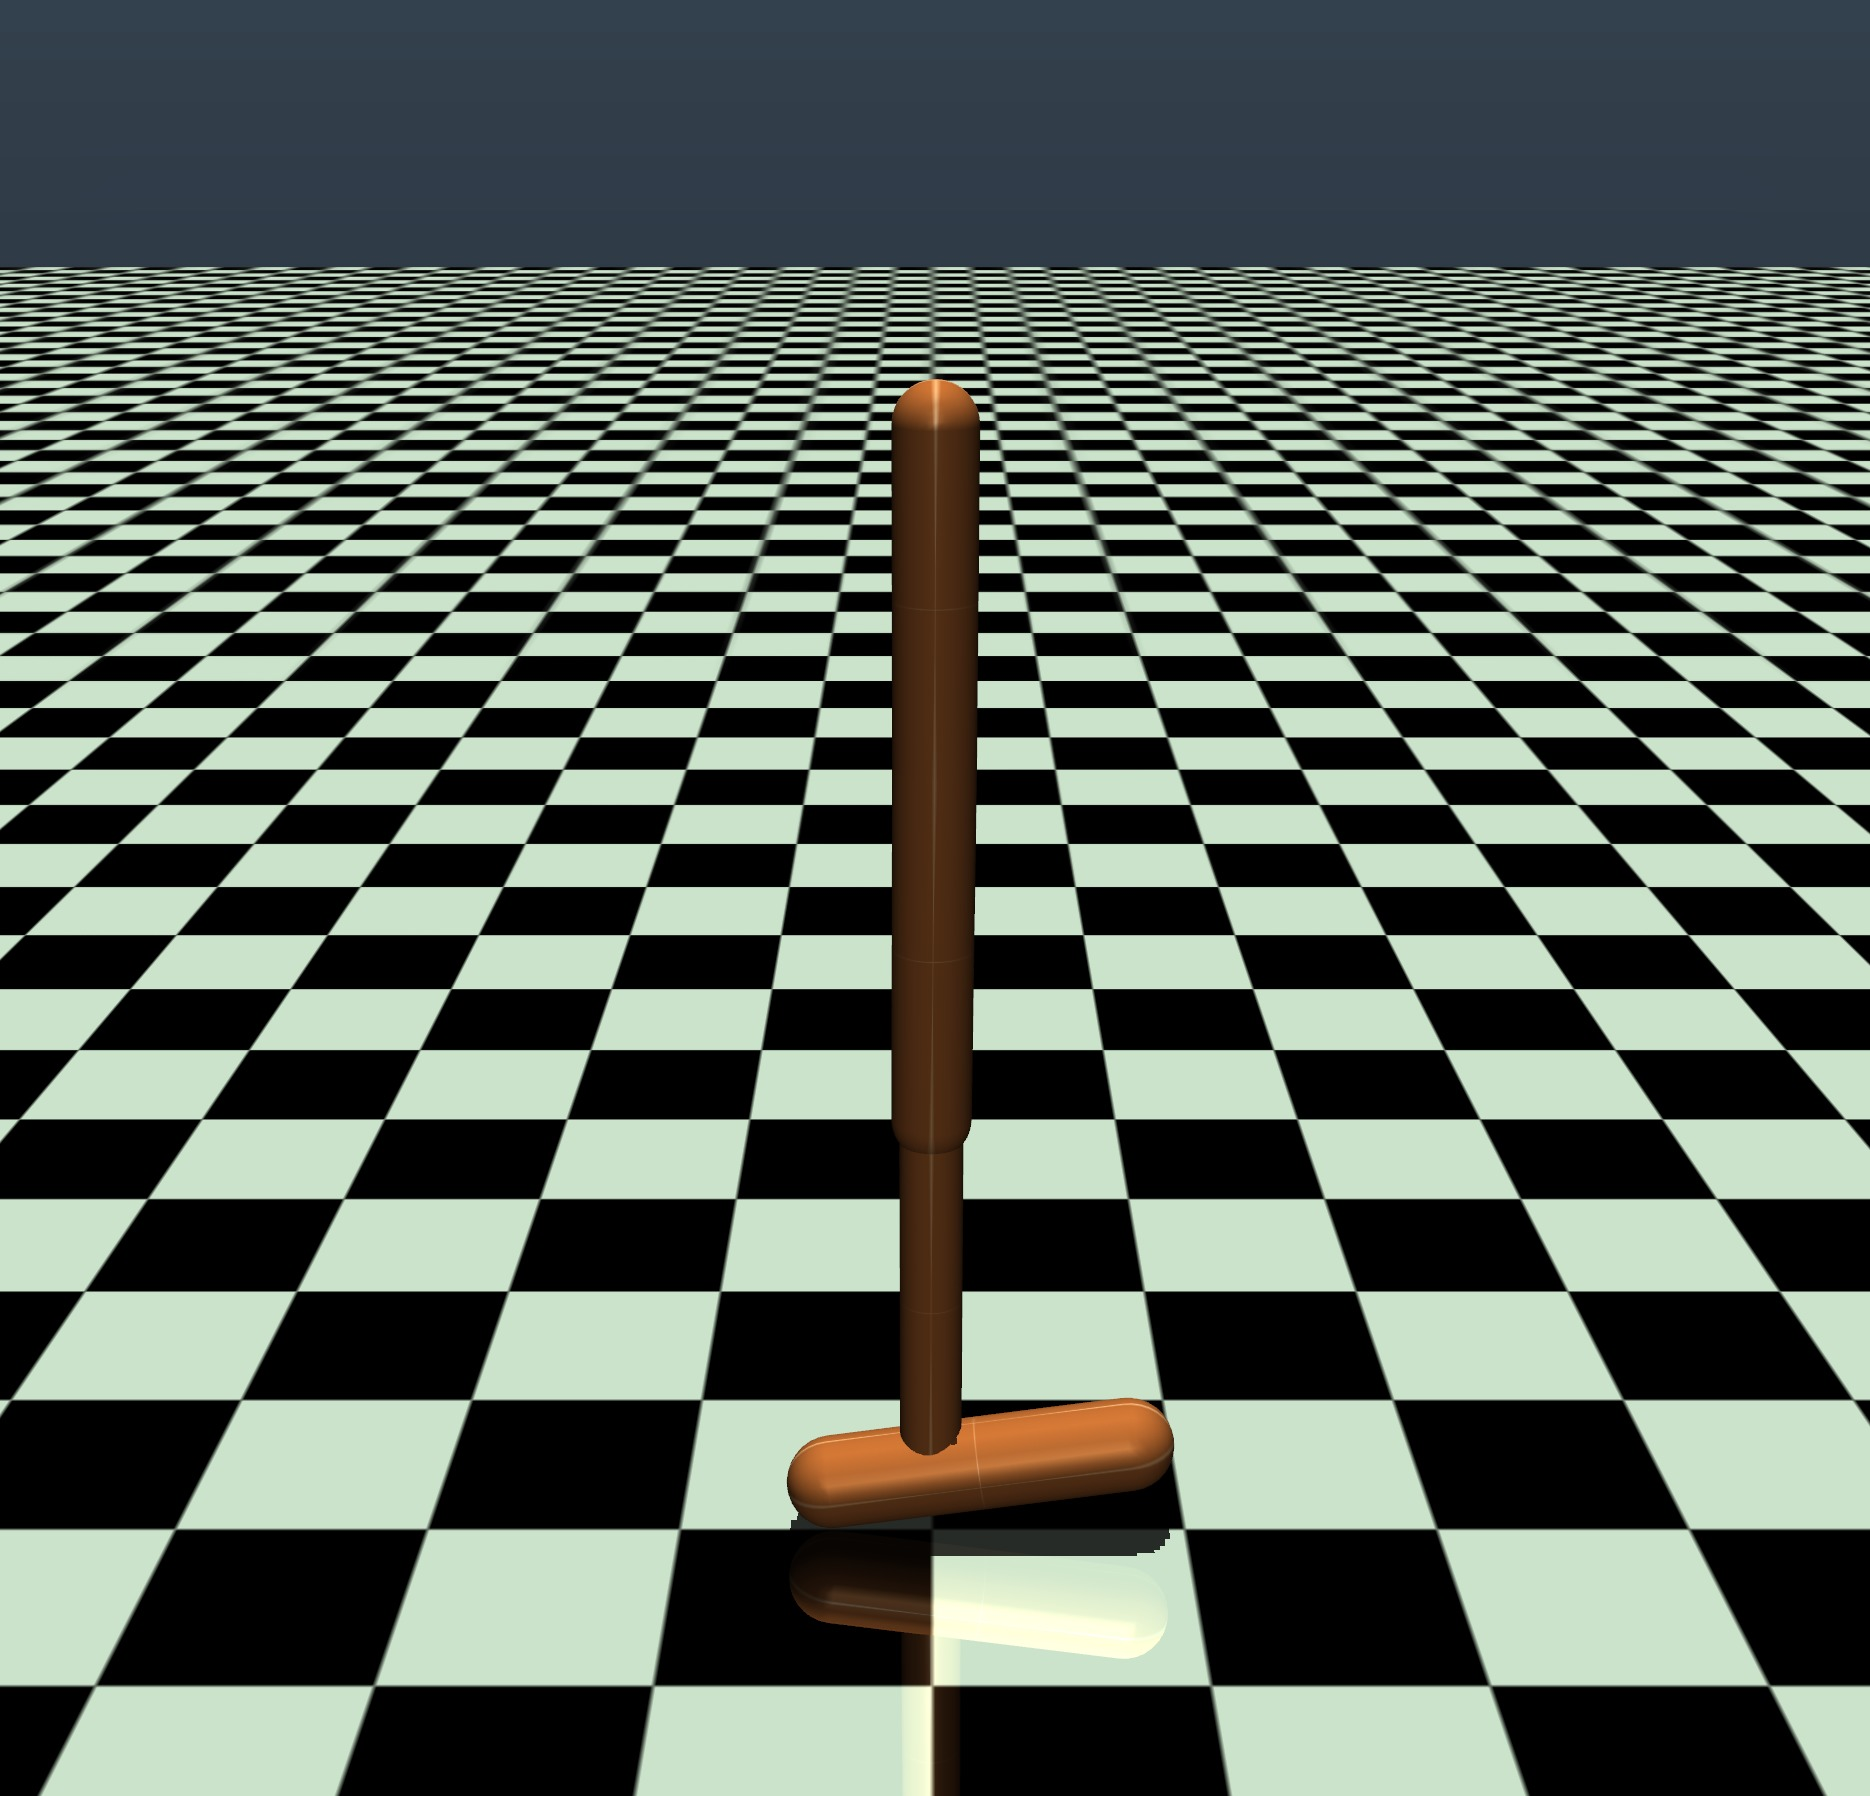


In [1]:
"""
I generate the training database using the code from `run_expert.py`
"""

import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy

def GenerateWarmupData(num_rollouts):
    """
    Generates a database of expert observation-action pair of size `num_rollouts` 
    """

    print('loading and building expert policy')
    policy_fn = load_policy.load_policy('experts/Hopper-v1.pkl')
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()
        # it is cool thing to note that not every library is imported at the beginning
        # Especially useful when loading multiple large libraries
        import gym
        env = gym.make('Hopper-v1')
        max_steps = env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(num_rollouts):
            print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            returns.append(totalr)
        
        print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))
        expert_data = {'observations': np.array(observations),
                       'actions': np.array(actions).squeeze()}
    return expert_data

/home/botoscs/.virtualenvs/all/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
expert_data = GenerateWarmupData(20)

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2018-04-08 20:16:08,240] From /home/botoscs/brdl-homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2018-04-08 20:16:08,251] From /home/botoscs/.virtualenvs/all/lib/python3.5/site-packages/tensorflow/python/util/tf_should_use.py:118: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2018-04-08 20:16:08,261] Making new env: Hopper-v1


iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
returns [3774.9592467429175, 3774.403442069187, 3773.1737005420205, 3774.525212719326, 3777.030596933036, 3777.7980935355886, 3776.017687595559, 3777.5729845532032, 3777.321982736748, 3778.425552301009, 3777.2645670835254, 3782.3512880324147, 3779.095879693781, 3791.320222371548, 3775.6173334507744, 3780.1377078163982, 3779.522614479995, 3782.4608229978885, 3774.672826316517, 3779.507495624121]
mean return 3778.1589628797774
std of return 3.9159112498120017


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 10

(20000, 11)


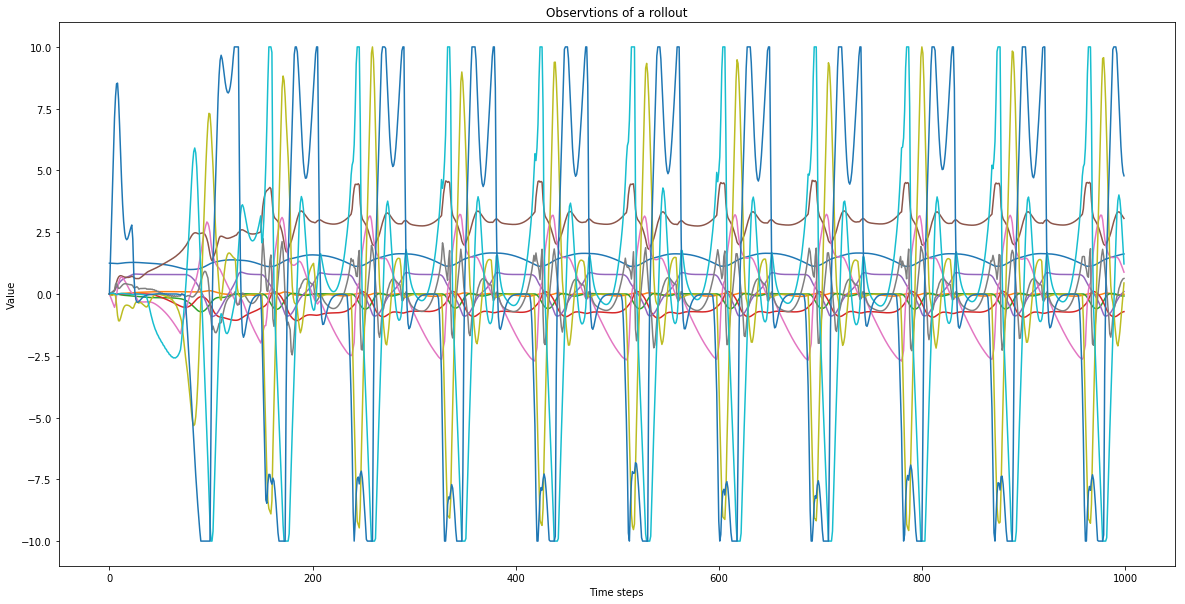

(20000, 3)


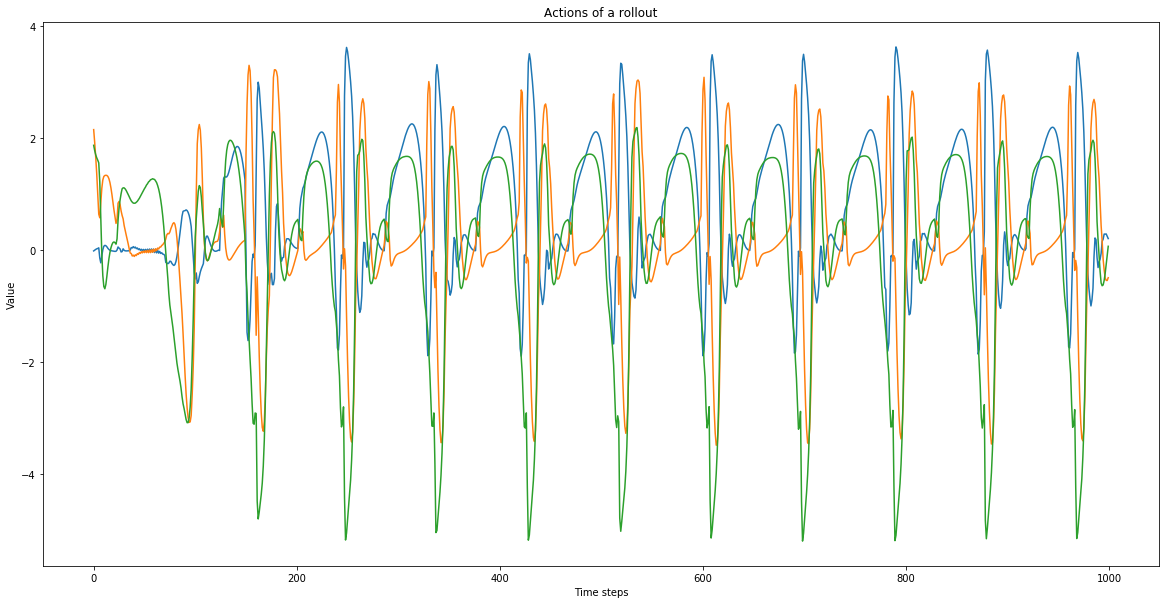

In [5]:
print(expert_data['observations'].shape)
plt.plot(expert_data['observations'][:1000])
plt.title('Observtions of a rollout')
plt.ylabel('Value')
plt.xlabel('Time steps')
plt.show()


print(expert_data['actions'].shape)
plt.plot(expert_data['actions'][:1000])
plt.title('Actions of a rollout')
plt.ylabel('Value')
plt.xlabel('Time steps')
plt.show()

In [6]:
"""
Now I just do the good-ol supervised learning
"""
import torch
from torch.nn import Linear, ReLU

def getMLP(input_dim, output_dim, hidden_dims):    
    """
    A vanilla MLP generator, with ReLU hidden, and Linear output layer
    """
    # Initial layers
    layers = [
        Linear(input_dim, hidden_dims[0]),
        ReLU()
    ]
    
    # Hidden layers
    prev_dim = hidden_dims[0]
    for h_dim in hidden_dims[1:]:
        layers.append(Linear(prev_dim, h_dim))
        layers.append(ReLU())
        prev_dim = h_dim
                   
    # Output layer
    layers.append(Linear(hidden_dims[-1], output_dim, bias=False))
    
    MLP = torch.nn.Sequential(*layers)
    return MLP

In [7]:
"""
Defining the policy network
"""
input_dim = expert_data['observations'].shape[-1]
output_dim = expert_data['actions'].shape[-1]
hidden_dims = [64]

policy_net = getMLP(input_dim, output_dim, hidden_dims)
print(policy_net)

Sequential(
  (0): Linear(in_features=11, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=3)
)


In [8]:
"""
Training the policy network
"""
from torch.autograd import Variable
from torch import FloatTensor

X = Variable(FloatTensor(expert_data['observations']))
Y = Variable(FloatTensor(expert_data['actions']))
if torch.cuda.is_available():
    X = X.cuda()
    Y = Y.cuda()
    policy_net.cuda()
    
loss = torch.nn.MSELoss()
opt = torch.optim.Adam(policy_net.parameters())
losses = []
num_epochs = 1000
for epoch in range(num_epochs):
    if epoch % (num_epochs//10) == 0: print('Epoch:', epoch)
    opt.zero_grad()
    actions = policy_net(X)
    L2 = loss(actions, Y)
    L2.backward()
    opt.step()
    losses.append(L2.cpu().data.numpy())

Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900


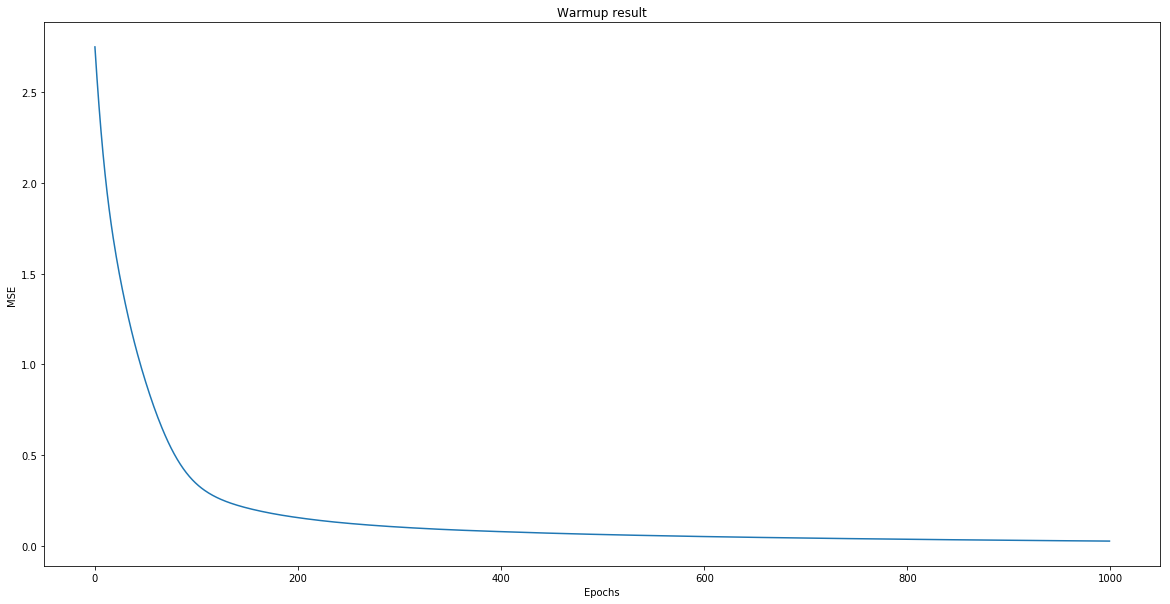

In [9]:
plt.plot(losses)
plt.title('Warmup result')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

## Testing the trained Hopper agent

In [10]:
def policy_wrapper(policy_net):
    def wrapped_policy_net(obs):
        X = Variable(FloatTensor(obs))
        if torch.cuda.is_available():
            X = X.cuda()

        return policy_net(X).cpu().data.numpy()
    return wrapped_policy_net

In [11]:
def TestAgent(policy_fn, env_name='Hopper', render=False, num_rollouts=3, show_after_done=False):
    returns = []
    observations = []
    actions = []
    env = gym.make(env_name+'-v1')
    for i in range(num_rollouts):
        print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done or show_after_done:
            action = policy_fn(obs[None,:])
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            observations.append(obs)
            actions.append(action)
            if render:
                env.render()
            #if steps % 100 == 0: print("%i/%i"%(steps, env.spec.timestep_limit))
            if steps >= env.spec.timestep_limit:
                break
        returns.append(totalr)

    if render:
        env.render(close=True)
    
    print('returns', returns)
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))
    agent_data = {'observations': np.array(observations),
                  'actions': np.array(actions)}
    return agent_data, returns

In [12]:
policy_fn = policy_wrapper(policy_net)
agent_data, returns = TestAgent(policy_fn, 'Hopper', True)

[2018-04-08 20:17:18,657] Making new env: Hopper-v1


iter 0
iter 1
iter 2
returns [219.58082427497223, 217.53131725064142, 219.35720942646324]
mean return 218.82311698402563
std of return 0.9179908545285406


## Section 3.  Behavioral Cloning

### Section 3.1
Run  behavioral  cloning  (BC)  and  report  results  on  two  other  tasks  –  one  task  where  a  behavioral cloning agent achieves comparable performance to the expert, and one task where it does not.  Whenproviding  results,  report  the  mean  and  standard  deviation  of  the  return  over  multiple  rollouts  in  atable, and state which task was used.  Be sure to set up a fair comparison, in terms of network size,amount of data, and number of training iterations, and provide these details (and any others you feel are appropriate) in the table caption

In [ ]:
"""
Generalize the steps required to carry out Behavioral Cloning
+====+
Formalize them into functions
"""

def GenerateExpertData(env_name, num_rollouts=20, render=True):
    """
    Generates a database of expert observation-action pair of size `num_rollouts` 
    """

    print('loading and building expert policy')
    policy_fn = load_policy.load_policy('experts/%s-v1.pkl'%env_name)
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()
        env = gym.make(env_name+'-v1')
        max_steps = env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(num_rollouts):
            print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                if render:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            returns.append(totalr)
        
        if render:
            env.render(close=True)

        print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))
        expert_data = {'observations': np.array(observations),
                       'actions': np.array(actions).squeeze()}
    return expert_data


def getMLP(input_dim, output_dim, hidden_dims):    
    """
    A vanilla MLP generator, with ReLU hidden, and Linear output layer
    """
    # Initial layers
    layers = [
        Linear(input_dim, hidden_dims[0]),
        ReLU()
    ]
    
    # Hidden layers
    prev_dim = hidden_dims[0]
    for h_dim in hidden_dims[1:]:
        layers.append(Linear(prev_dim, h_dim))
        layers.append(ReLU())
        prev_dim = h_dim
                   
    # Output layer
    layers.append(Linear(hidden_dims[-1], output_dim, bias=False))
    
    MLP = torch.nn.Sequential(*layers)
    return MLP


def BCAgent(expert_data, hidden_dims=[64], num_epochs=1000, 
            loss_fn=torch.nn.MSELoss(), pretrained_agent=None):
    # STEP 1: Define policy-network
    if pretrained_agent:
        # Useful if you want to fine-tune the policy-network
        policy_net = pretrained_agent
    else:        
        input_dim = expert_data['observations'].shape[-1]
        output_dim = expert_data['actions'].shape[-1]
        policy_net = getMLP(input_dim, output_dim, hidden_dims)
    print('Agent\'s Policy function:\n', policy_net)
    
    # STEP 2: Load the training data into PyTorch Tensors
    X = Variable(FloatTensor(expert_data['observations']))
    Y = Variable(FloatTensor(expert_data['actions']))
    if torch.cuda.is_available():
        X = X.cuda()
        Y = Y.cuda()
        policy_net.cuda()
        
    # STEP 3: Initialize and do the training    
    opt = torch.optim.Adam(policy_net.parameters())
    losses = []
    for epoch in range(num_epochs):
        if epoch % (num_epochs//10) == 0: print('Epoch:', epoch)
        opt.zero_grad()
        actions = policy_net(X)
        loss = loss_fn(actions, Y)
        loss.backward()
        opt.step()
        losses.append(loss.cpu().data.numpy())

    print('Behaviour cloning finished')
    plt.plot(losses)
    plt.title('BC result')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.show()
    
    return policy_net

def policy_wrapper(policy_net):
    """
    A generator function that wraps a NumPy->PyTorch->NumPy conversion in the background
    """
    def wrapped_policy_net(obs):
        X = Variable(FloatTensor(obs))
        if torch.cuda.is_available():
            X = X.cuda()
        return policy_net(X).cpu().data.numpy()
    return wrapped_policy_net

def TestAgent(policy_fn, env_name='Hopper', render=False, 
              num_rollouts=3, show_after_done=False):
    
    """
    Whether the agent is an expert, or trained - implemented in TF / PyTorch
    it should be able to respond to the env via `policy_fn`
    """
    returns = []
    observations = []
    actions = []
    env = gym.make(env_name+'-v1')
    for i in range(num_rollouts):
        print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        # show_after_done is just a funny feature that enables you to watch agents
        # do some weird break-dance moves even if the env would stop them to do so
        while not done or show_after_done:
            action = policy_fn(obs[None,:])
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            observations.append(obs)
            actions.append(action)
            if render:
                env.render()
            #if steps % 100 == 0: print("%i/%i"%(steps, env.spec.timestep_limit))
            if steps >= env.spec.timestep_limit:
                break
        returns.append(totalr)

    if render:
        env.render(close=True)
    
    print('returns', returns)
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))
    agent_data = {'observations': np.array(observations),
                  'actions': np.array(actions)}
    return agent_data, returns


def VisualizeAgentData(agent_data, rollout_length=1000):
    """
    Just to have some non-MuJoCo intention about the input-output signals
    """
    
    print(agent_data['observations'].shape)
    plt.plot(agent_data['observations'][:rollout_length])
    plt.title('Observtions of a rollout')
    plt.ylabel('Value')
    plt.xlabel('Time steps')
    plt.show()


    print(agent_data['actions'].shape)
    plt.plot(agent_data['actions'][:rollout_length])
    plt.title('Actions of a rollout')
    plt.ylabel('Value')
    plt.xlabel('Time steps')
    plt.show()

### Testing Ant

In [ ]:
ant_expert_data = GenerateExpertData('Ant', num_rollouts=20, render=False)

In [ ]:
ant_policy_network = BCAgent(ant_expert_data, num_epochs=1000)

In [ ]:
ant_policy_fn = policy_wrapper(ant_policy_network)
ant_agent_data, ant_returns = TestAgent(ant_policy_fn, env_name='Ant', 
                                        render=True, num_rollouts=10)

### Testing HalfCheetah

In [ ]:
HC_expert_data = GenerateExpertData('HalfCheetah', num_rollouts=20, render=False)

In [ ]:
HC_policy_network = BCAgent(HC_expert_data, num_epochs=1000)

In [ ]:
HC_policy_fn = policy_wrapper(HC_policy_network)
HC_agent_data, HC_returns = TestAgent(HC_policy_fn, env_name='HalfCheetah', 
                                      render=False, num_rollouts=10)

### Testing Humanoid

In [ ]:
hum_expert_data = GenerateExpertData('Humanoid', num_rollouts=20, render=False)

In [ ]:
hum_policy_network = BCAgent(hum_expert_data, num_epochs=1000)

In [ ]:
hum_policy_fn = policy_wrapper(hum_policy_network)
hum_agent_data, hum_returns = TestAgent(hum_policy_fn, env_name='Humanoid', 
                                        render=False, num_rollouts=10)

## Table 1

- Expert rollouts: 20
- Hidden: 64 (ReLU)
- Optimizer: Adam (1000 epoch)
- Results from 10 rollouts

(The exact vales may change, since seed was not fixed, still the relations were the same between multiple runs)

Task | Rewards mean | Rewards std
--- | --- | ---
Hopper (expert) | **3779.34** | 3.73
Hopper (ours) | 145.29 | 0.61
Ant (expert) | 4608.11 | 788.98
Ant (ours) | **4724.66** | 133.33
HalfCheetah (expert) | **4156.78** | 90.93
HalfCheetah (ours) | 3012.47 | 219.77
Humanoid (expert) | **10415.85** | 33.61
Humanoid (ours) | 419.70 | 100.55

### Section 3.2

Experiment with one hyperparameter that affects the performance of the behavioral cloning agent, such as the number of demonstrations, the number of training epochs, the variance of the expert policy, or something that you come up with yourself.  For one of the tasks used in the previous question, show a graph of how the BC agent’s performance varies with the value of this hyperparameter, and state the hyperparameter and a brief rationale for why you chose it in the caption for the graph.

In [ ]:
mean_rewards = []
test_values = [10, 50, 100, 250, 500, 750, 1000, 1500]
for num_epochs in test_values:
    ant_policy_network = BCAgent(ant_expert_data, num_epochs=num_epochs)
    ant_policy_fn = policy_wrapper(ant_policy_network)
    ant_agent_data, ant_returns = TestAgent(ant_policy_fn, env_name='Ant', render=False, num_rollouts=10)
    mean_rewards.append(np.mean(ant_returns))

## Figure 1

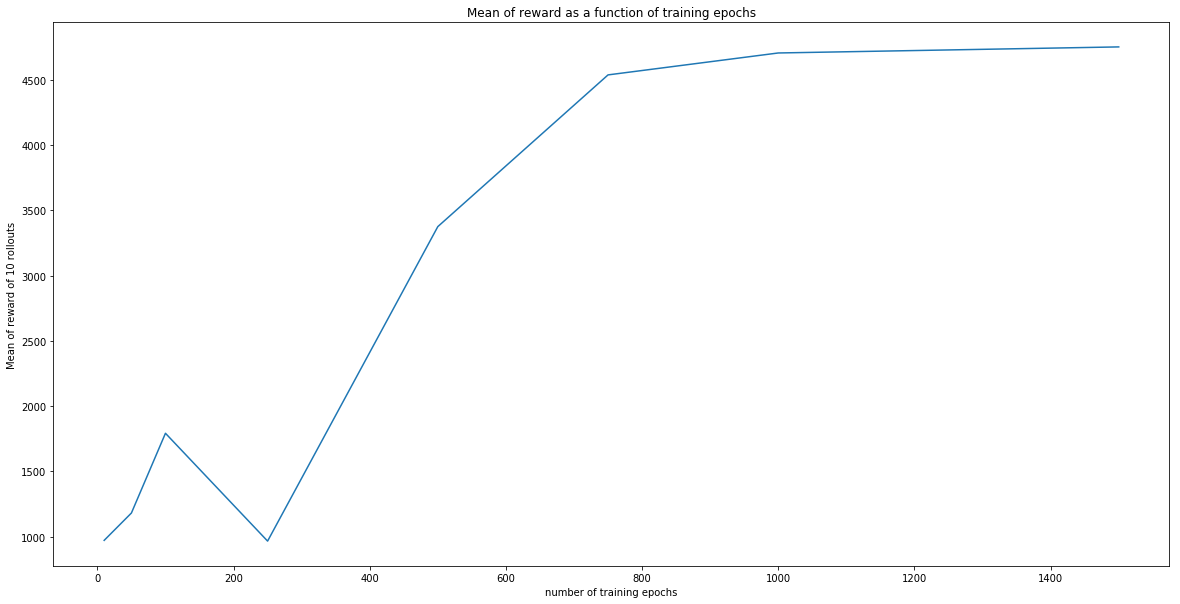

In [69]:
plt.plot(test_values, mean_rewards)
plt.title('Mean of reward as a function of training epochs')
plt.xlabel('number of training epochs')
plt.ylabel('Mean of reward of 10 rollouts')
plt.show()

#### CAPTION:

In the very first implementations none of the trained agents could achieve any decent performance, mainly because of the lack of enough training time. Therefore it seemed interesting to me to depict the curve of the performance wrt. the # of epochs

In [ ]:
hidden_mean_rewards = []
test_values = range(2, 32)
for hidden_dim in test_values:
    ant_policy_network = BCAgent(ant_expert_data, hidden_dims=[hidden_dim], num_epochs=1000)
    ant_policy_fn = policy_wrapper(ant_policy_network)
    ant_agent_data, ant_returns = TestAgent(ant_policy_fn, env_name='Ant', render=False, 
                                            num_rollouts=3)
    hidden_mean_rewards.append(np.mean(ant_returns))

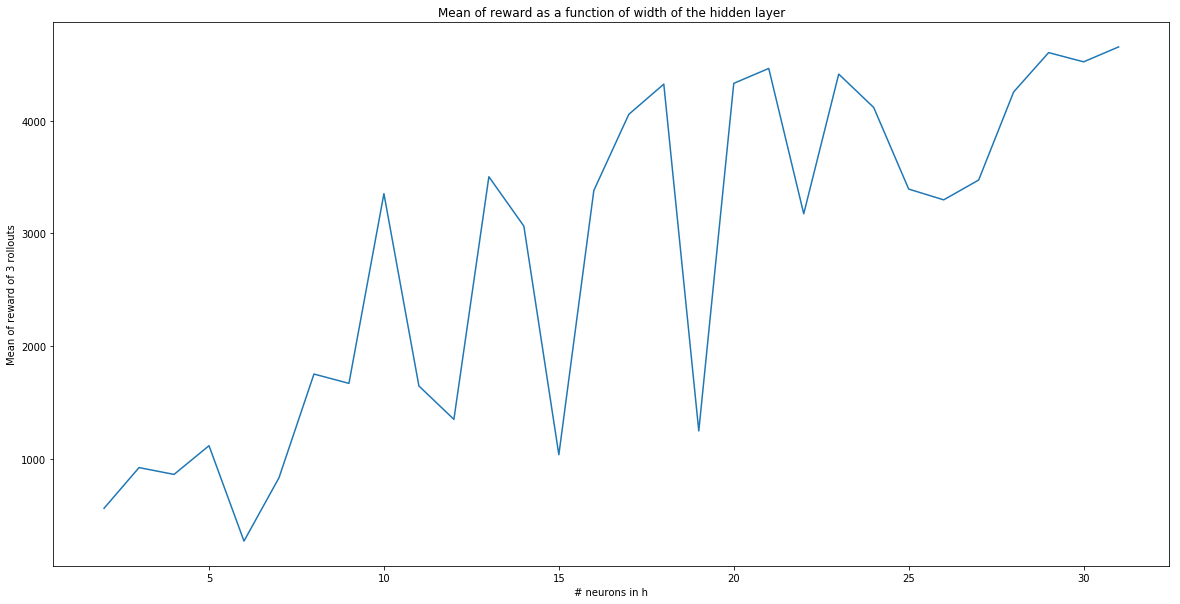

In [84]:
plt.plot(test_values, hidden_mean_rewards)
plt.title('Mean of reward as a function of width of the hidden layer')
plt.xlabel('# neurons in h')
plt.ylabel('Mean of reward of 3 rollouts')
plt.show()

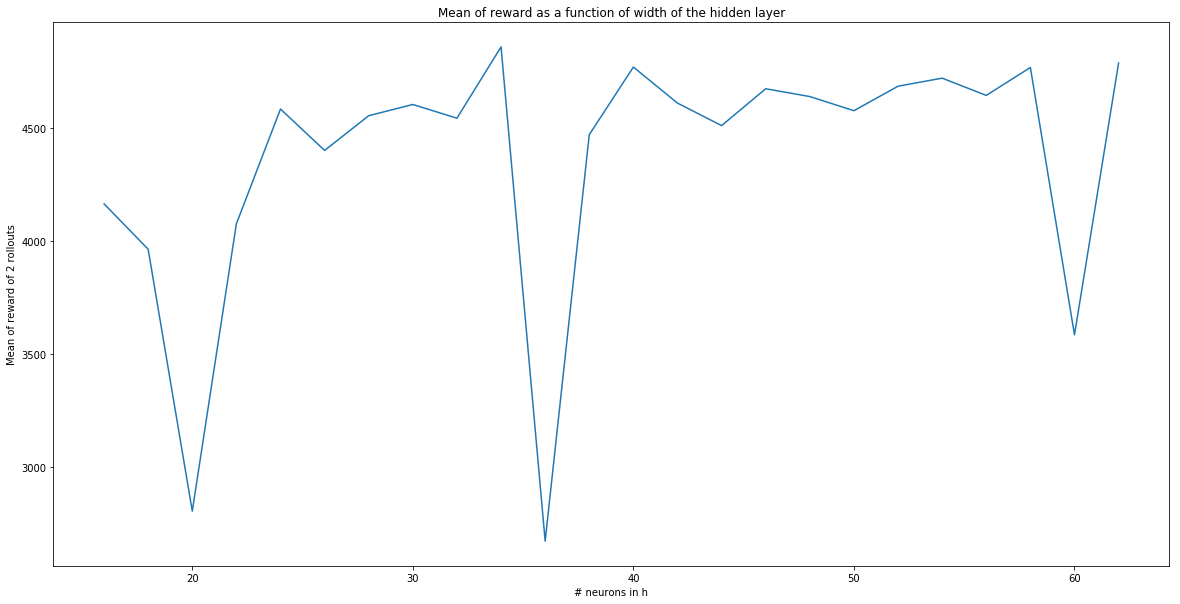

In [82]:
plt.plot(test_values, hidden_mean_rewards)
plt.title('Mean of reward as a function of width of the hidden layer')
plt.xlabel('# neurons in h')
plt.ylabel('Mean of reward of 2 rollouts')
plt.show()

It may be an expensive but quite describing metric if we take the performance as the function of the capacity of the underlying neural network.

As it was pointed out in [Deep Reinforcement Learning that Matters](https://arxiv.org/pdf/1709.06560.pdf): often there is no consistency in the type of network architectures and activation functions that are used in related literature. As shown in the paper and from our experimental results in later sections, we find, however, that these hyperparameters can have a significant effect in the performance of algorithms across benchmark environments typically used.

Maybe I should also experiment with the depth of the policy network, but that would be an overkill for now.

## Section 4. DAgger

### Section 4.1
Implement Domain Aggregation (DAgger). See the code provided in `run_expert.py` to see how to query the expert policy and perform roll-outs in the environment.

In [38]:
def SolveWithExpert(agent_data, env_name='Humanoid'):
    """
    Gives the observations of an imperfect agent and provides expert's solutions for them
    """
    
    policy_fn = load_policy.load_policy('experts/%s-v1.pkl'%env_name)
    
    with tf.Session():
        tf_util.initialize()
        # WWJD
        expert_action = policy_fn(agent_data['observations'])
    
    expert_data = {'observations': agent_data['observations'],
                   'actions': expert_action}
    return expert_data
    

# Aggregate

In [167]:
def Aggregate(D, D_pi):
    """
    Aggregate the training database (D):
    - observations of the trained agent (D_pi)
    - actions of an expert agent (a)
    """
    print(D['observations'].shape, D_pi['observations'].shape)
    dagger_data = {
    'observations' : np.concatenate([D['observations'], D_pi['observations']]),
    'actions' : np.concatenate([D['actions'], D_pi['actions']]),
    }
    
    return dagger_data

### Section 4.2
Run DAgger and report results on one task in which DAgger can learn a better policy than behavioral cloning.  Report your results in the form of a learning curve, plotting the number of DAgger iterations vs.  the policy’s mean return, with error bars to show the standard deviation.  Include the performance of the expert policy and the behavioral cloning agent on the same plot.  In the caption, state which task you used, and any details regarding network architecture, amount of data, etc.  (as in the previous section).

In [39]:
# Storing the original experiments
orig_expert_data = hum_expert_data.copy()
env_name = 'Humanoid'

In [45]:
for v in agent_data.values():
    print(v.shape)

(330, 1, 17)
(330, 376)


Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


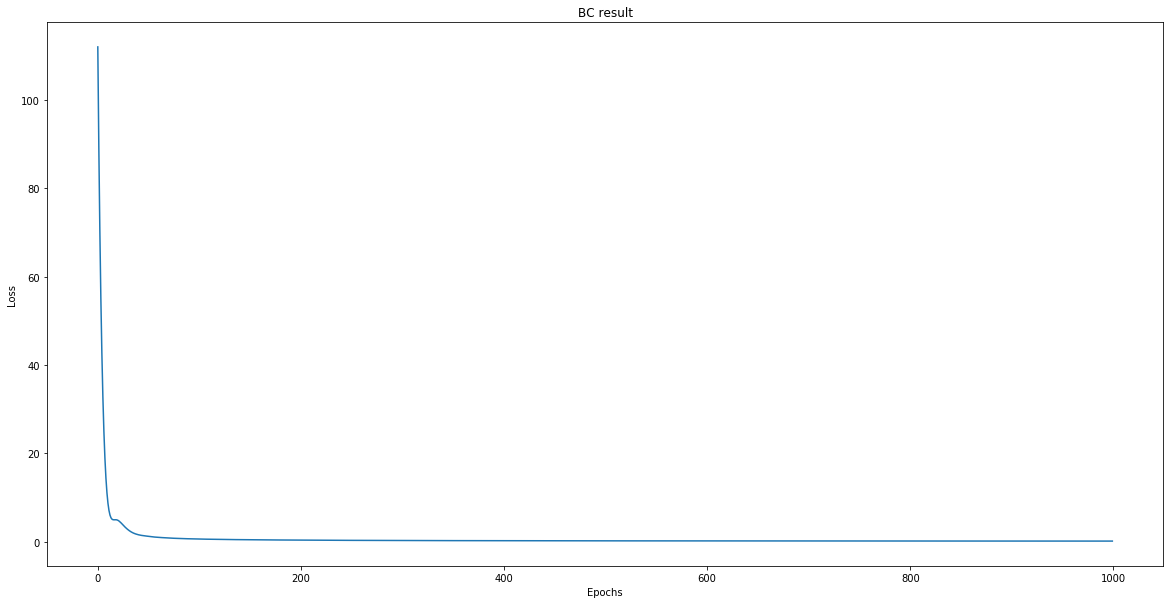

[2018-04-08 21:50:37,725] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [601.5502302627312, 339.796780066059, 299.12937100188543]
mean return 413.4921271102252
std of return 134.00956971049283
iter: 0
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


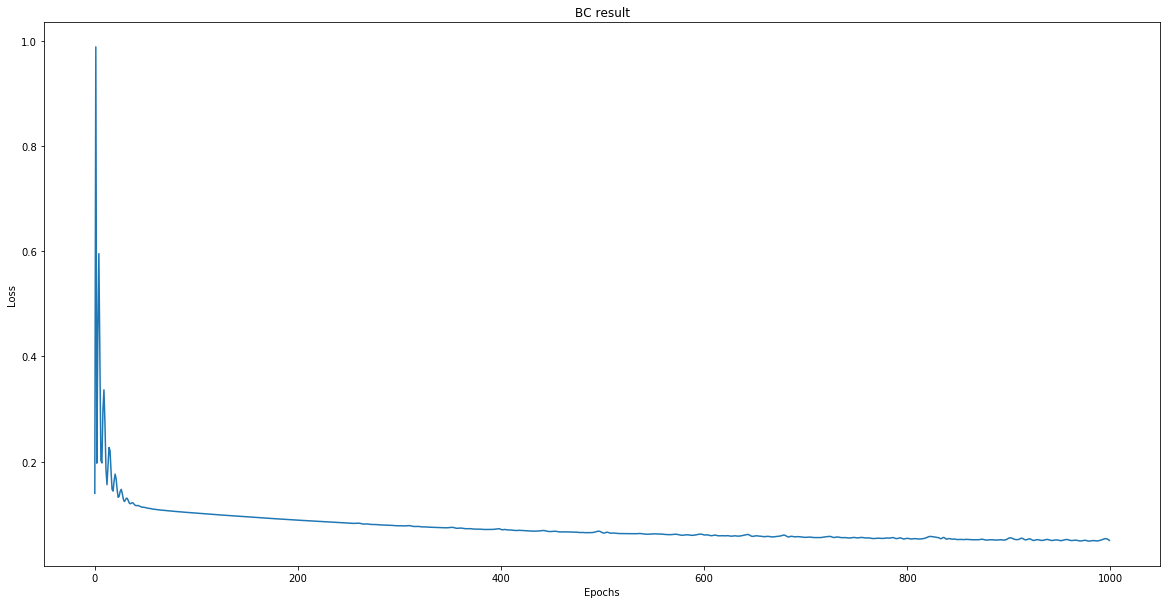

[2018-04-08 21:50:42,637] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [1886.3442083665755, 666.7878352772728, 917.6264237592987]
mean return 1156.9194891343823
std of return 525.8487204118288
iter: 1
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


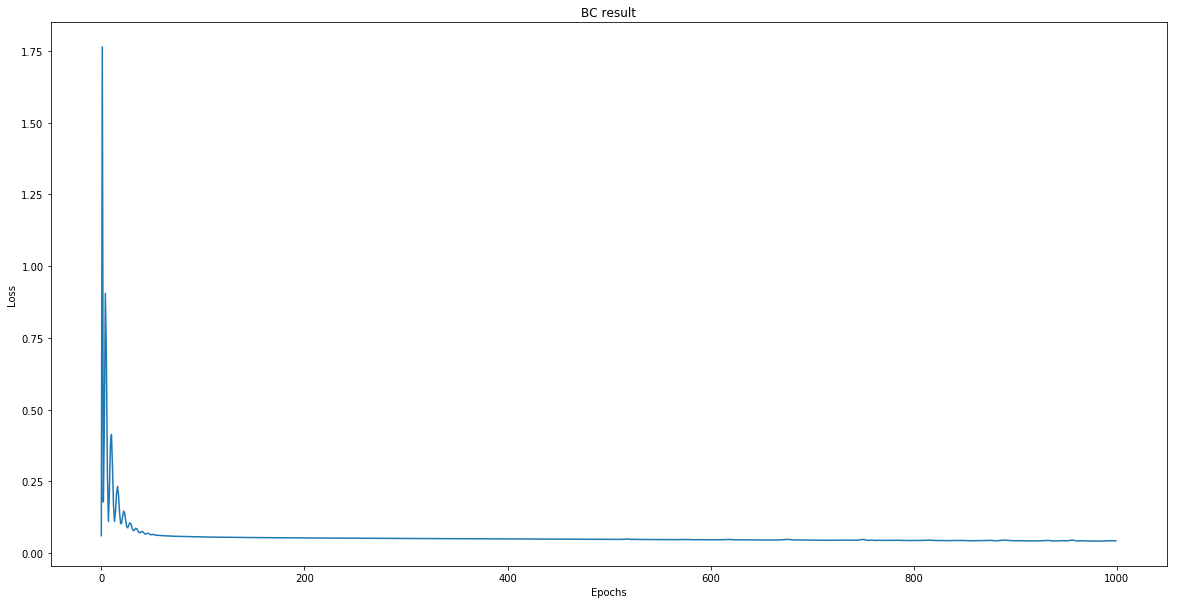

[2018-04-08 21:50:48,168] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [1903.6368379808825, 501.8827924498793, 877.0516334364788]
mean return 1094.1904212890802
std of return 592.5034688692864
iter: 2
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


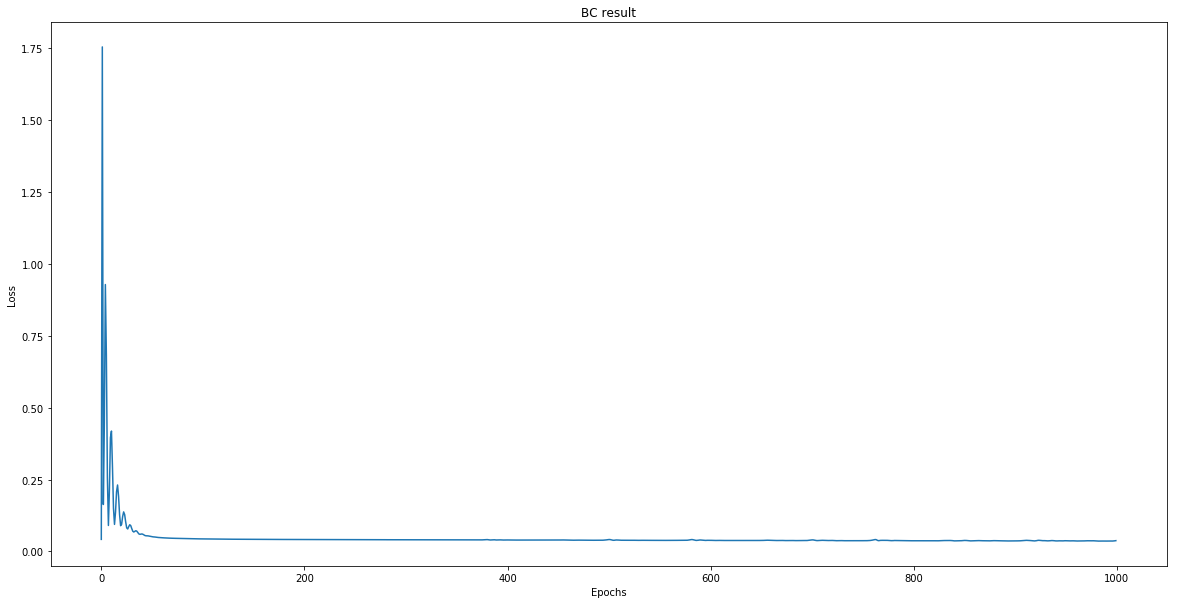

[2018-04-08 21:50:53,520] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [2547.0340681644907, 3451.425110088671, 1817.264743307744]
mean return 2605.2413071869687
std of return 668.4115938029792
iter: 3
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


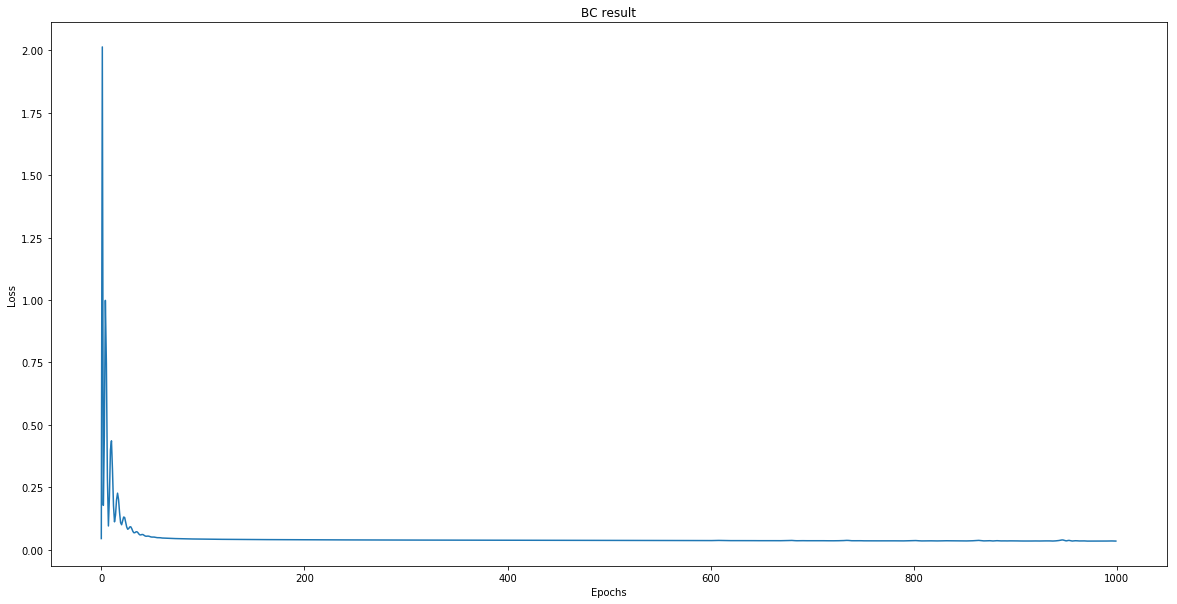

[2018-04-08 21:50:59,191] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [1366.0883204564034, 1887.6851119534113, 2521.124721971544]
mean return 1924.966051460453
std of return 472.2779362085827
iter: 4
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


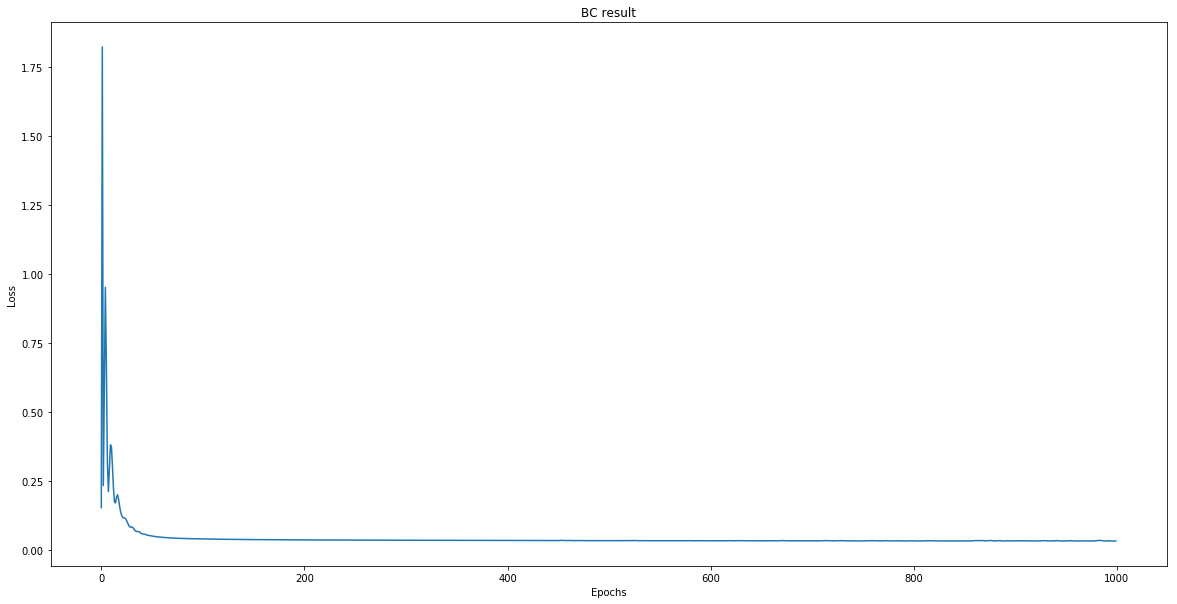

[2018-04-08 21:51:04,639] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [1601.0596825703276, 1762.3098251415024, 3467.1345607753747]
mean return 2276.834689495735
std of return 844.2395946633678
iter: 5
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


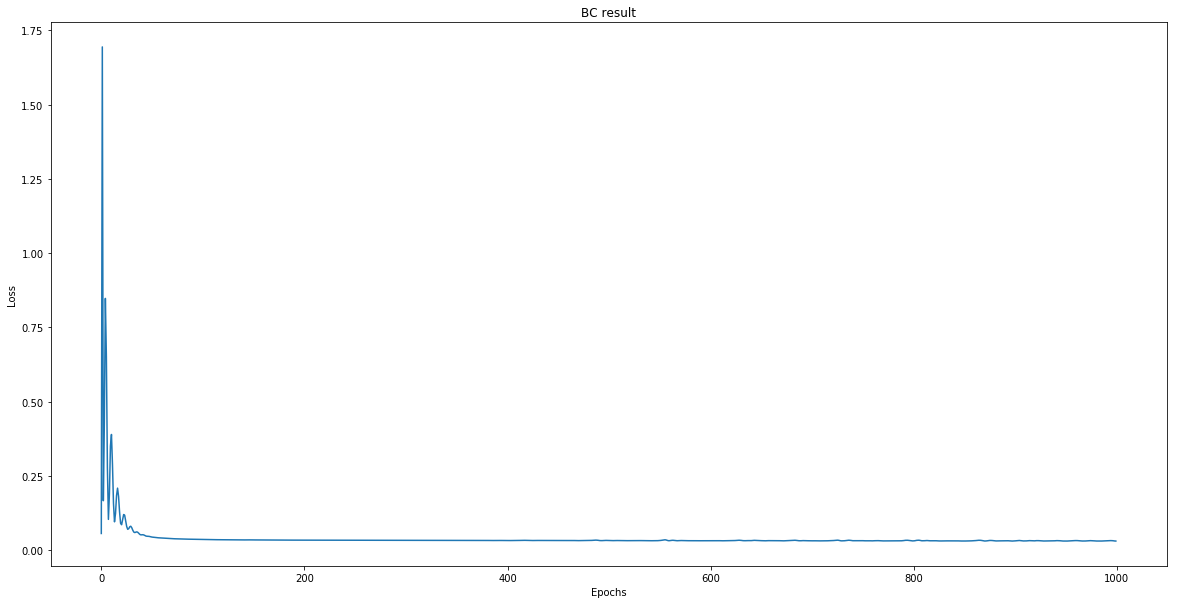

[2018-04-08 21:51:10,285] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [1146.0416223066468, 3952.1442515856925, 4300.479168695595]
mean return 3132.8883475293114
std of return 1412.091648528407
iter: 6
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


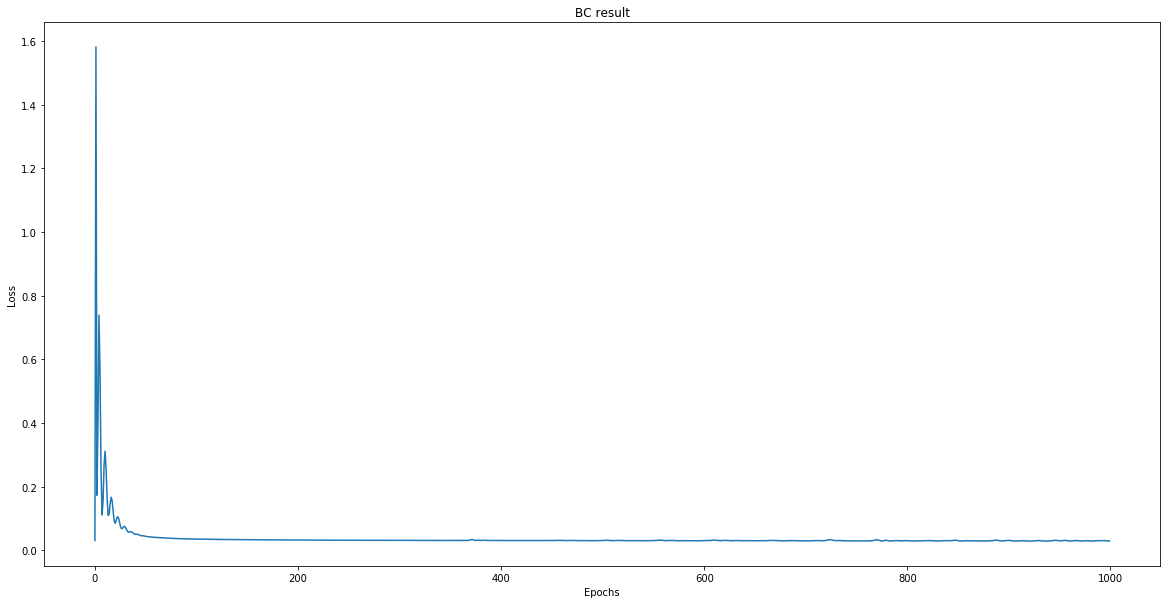

[2018-04-08 21:51:17,043] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [3399.9663746910514, 785.7838326587926, 4211.928180997617]
mean return 2799.226129449153
std of return 1461.7986422220831
iter: 7
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


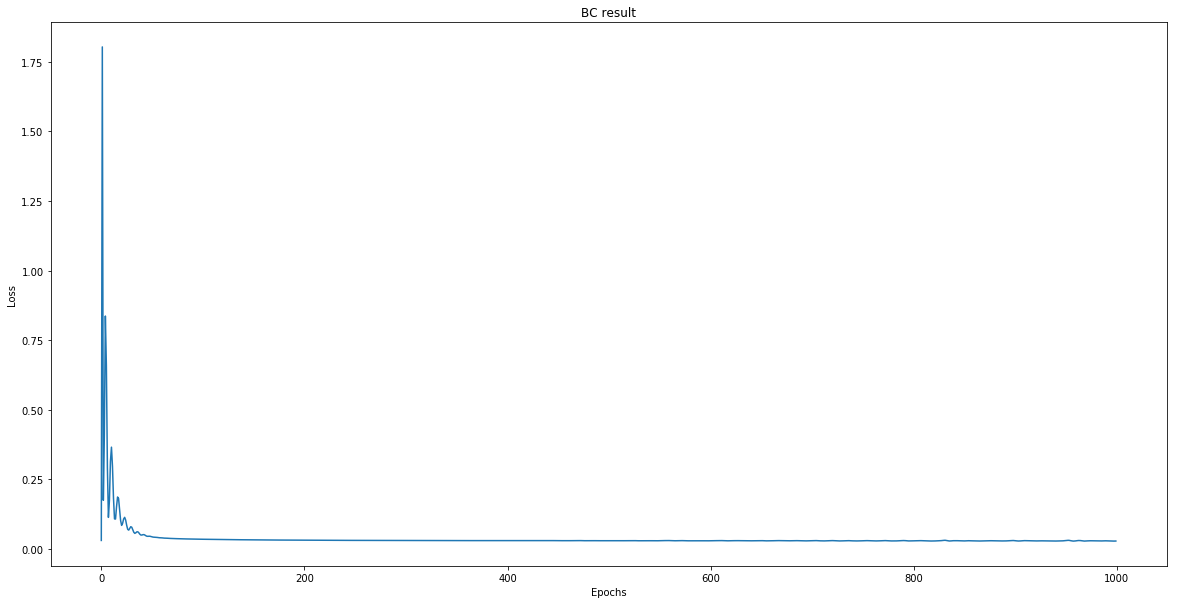

[2018-04-08 21:51:23,699] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [4514.951292064616, 3002.333454027002, 5708.258048040786]
mean return 4408.514264710801
std of return 1107.2499289429052
iter: 8
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


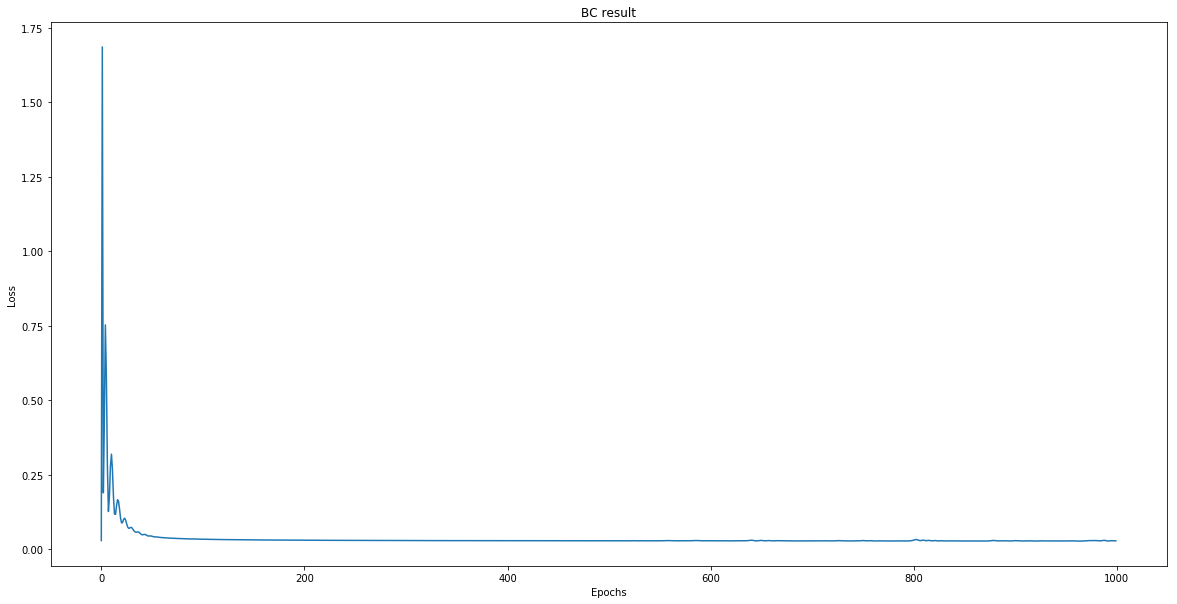

[2018-04-08 21:51:31,367] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [8184.874845506117, 2883.6777071262045, 10371.030190079833]
mean return 7146.527580904051
std of return 3143.642853169754
iter: 9
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


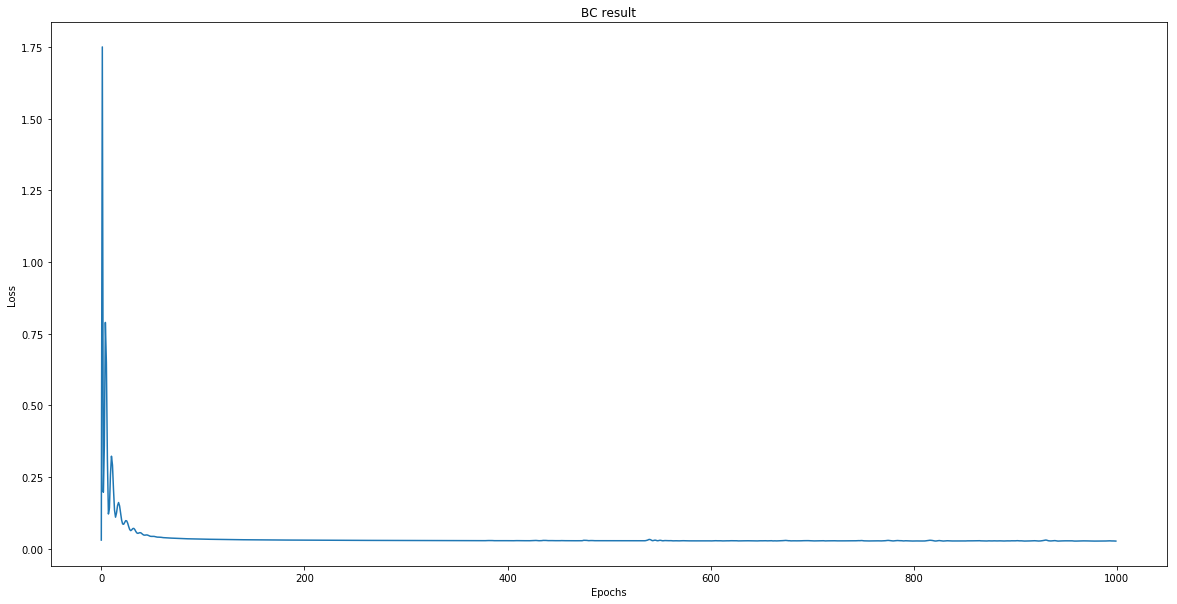

[2018-04-08 21:51:40,334] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10430.893255413323, 10408.95145708419, 2268.454189577112]
mean return 7702.766300691542
std of return 3842.6493856350558
iter: 10
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


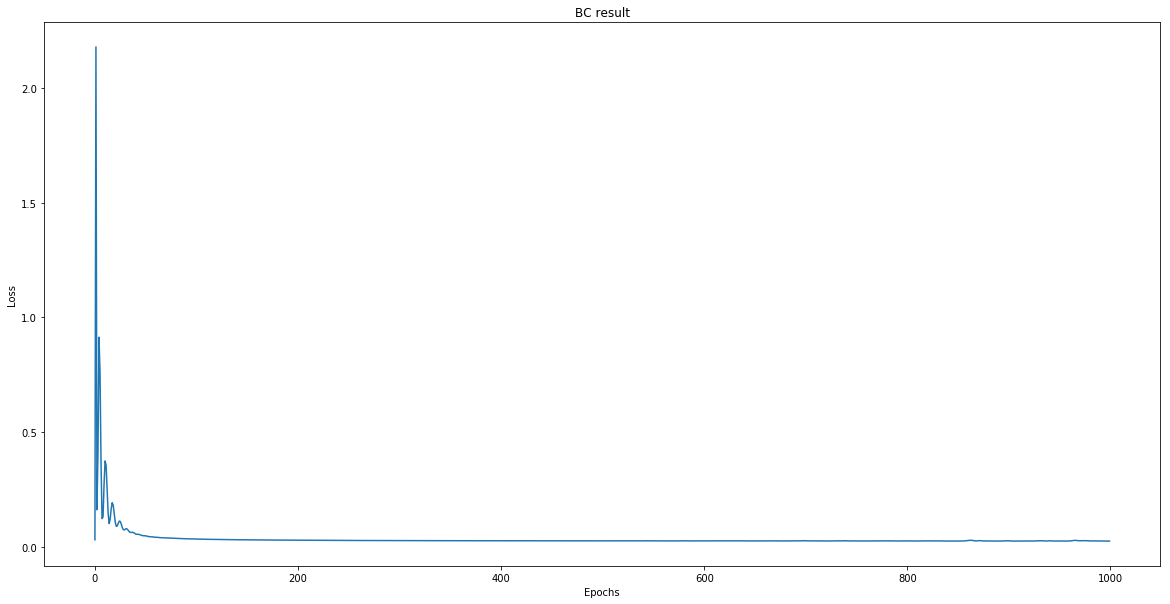

[2018-04-08 21:51:49,513] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [6134.383300753458, 4266.165832377448, 7682.971334671652]
mean return 6027.840155934186
std of return 1396.9379708032784
iter: 11
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


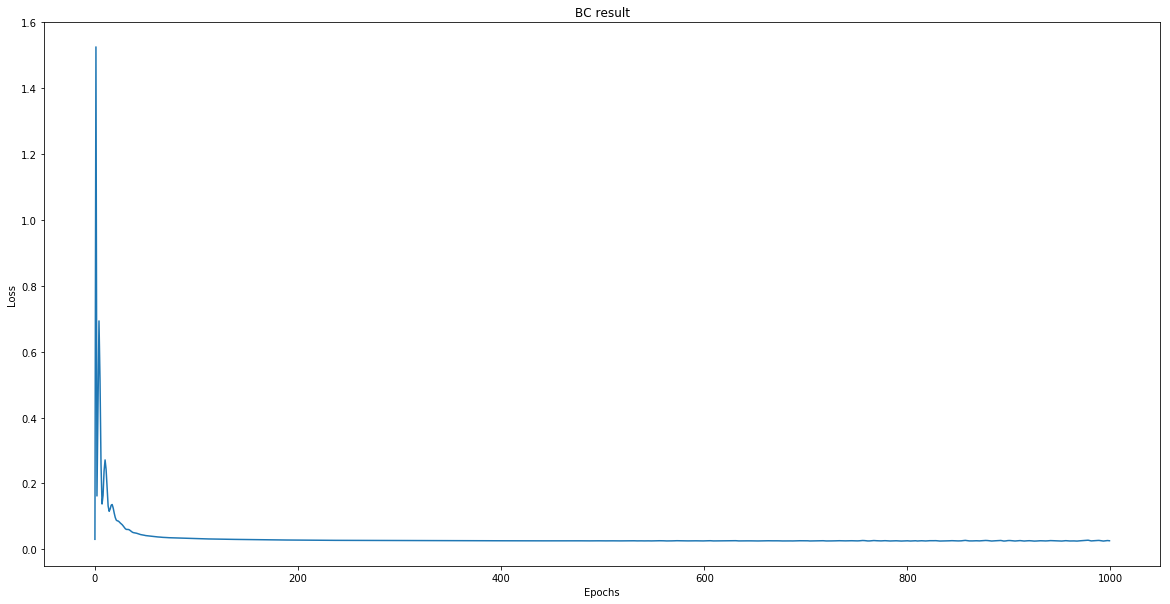

[2018-04-08 21:51:58,088] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [3018.642216449613, 6510.692259282125, 1499.6832287609266]
mean return 3676.339234830888
std of return 2097.931823166483
iter: 12
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


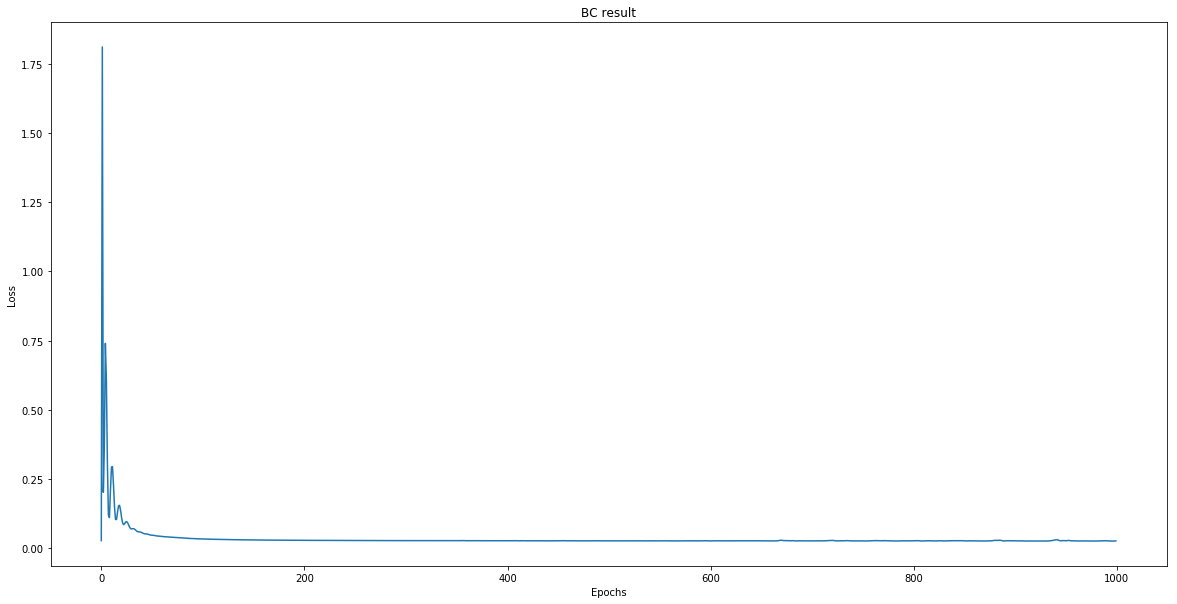

[2018-04-08 21:52:07,113] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [1791.5550870924856, 3726.4343905004484, 10393.971450783753]
mean return 5303.986976125562
std of return 3684.824368848099
iter: 13
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


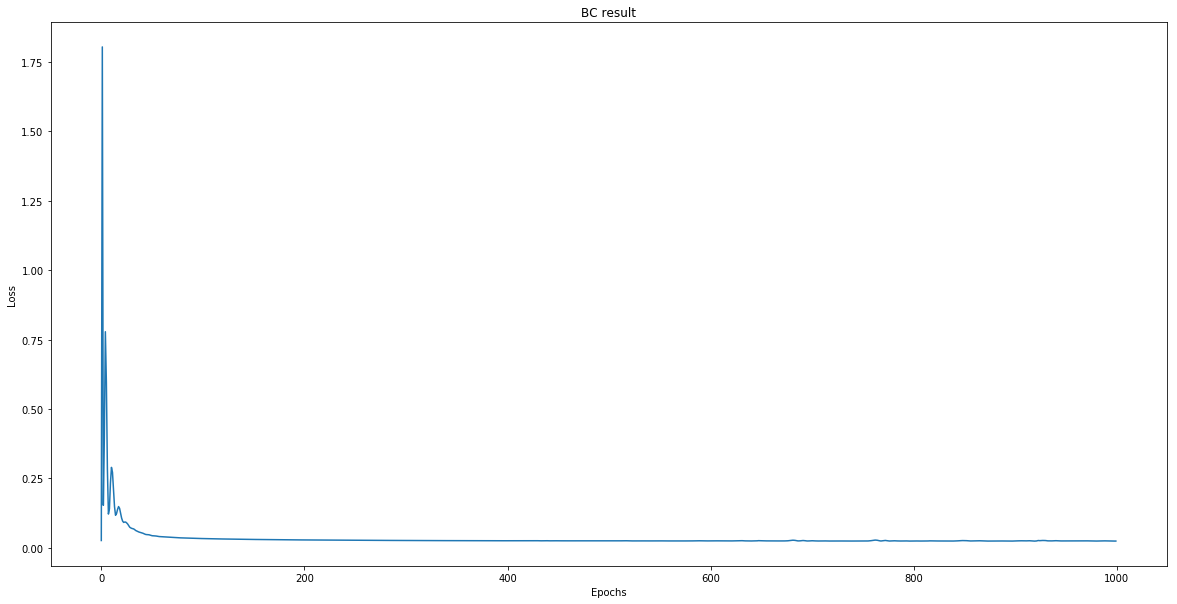

[2018-04-08 21:52:17,225] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10435.226633802835, 9091.341232677572, 3879.4111043095427]
mean return 7801.992990263317
std of return 2827.4244442423687
iter: 14
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


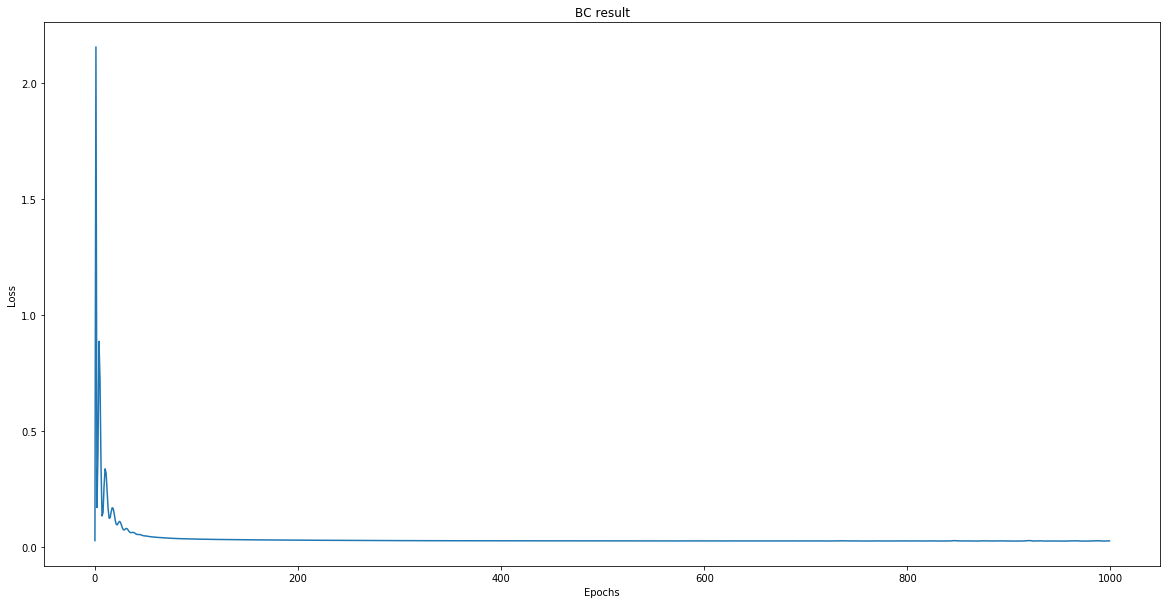

[2018-04-08 21:52:28,683] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10365.344580431165, 10339.326867311962, 10355.246644546774]
mean return 10353.3060307633
std of return 10.709959084289888
iter: 15
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


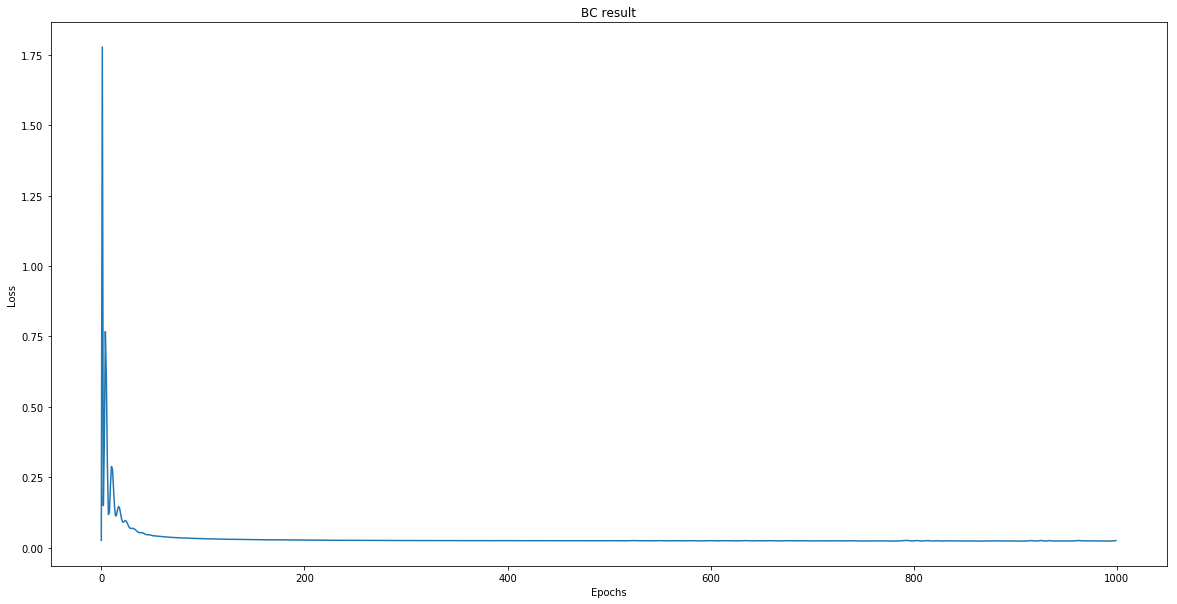

[2018-04-08 21:52:41,725] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10382.772008283255, 978.4974225705569, 7052.005187816459]
mean return 6137.758206223424
std of return 3893.325979877566
iter: 16
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


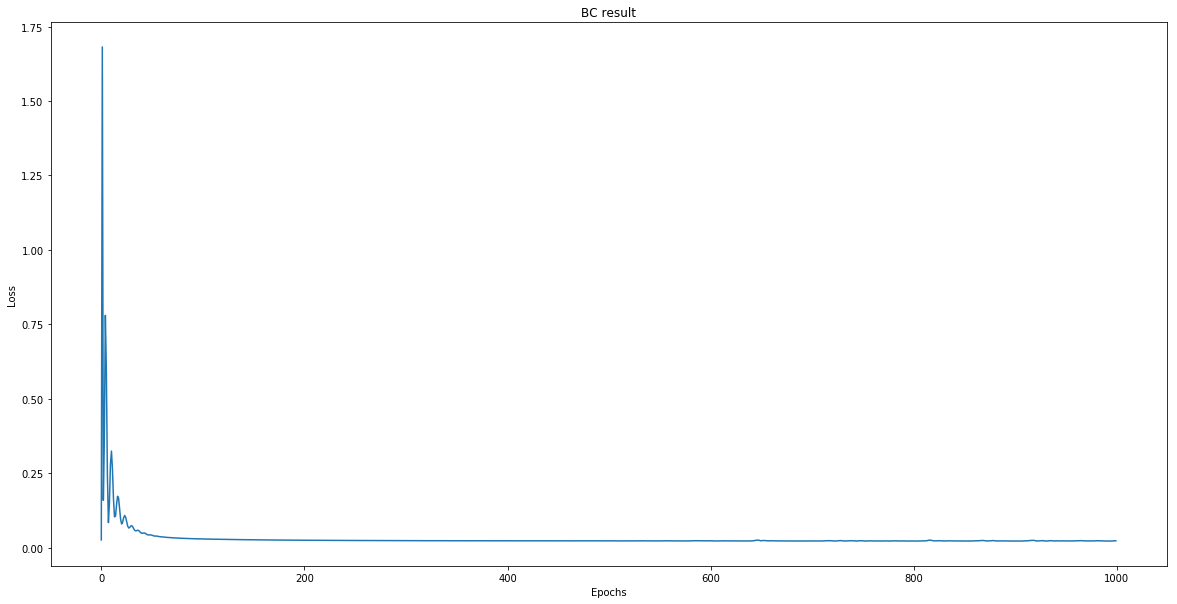

[2018-04-08 21:52:52,103] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10404.32506910526, 10346.411514367464, 10416.973058928503]
mean return 10389.236547467075
std of return 30.718946451436278
iter: 17
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


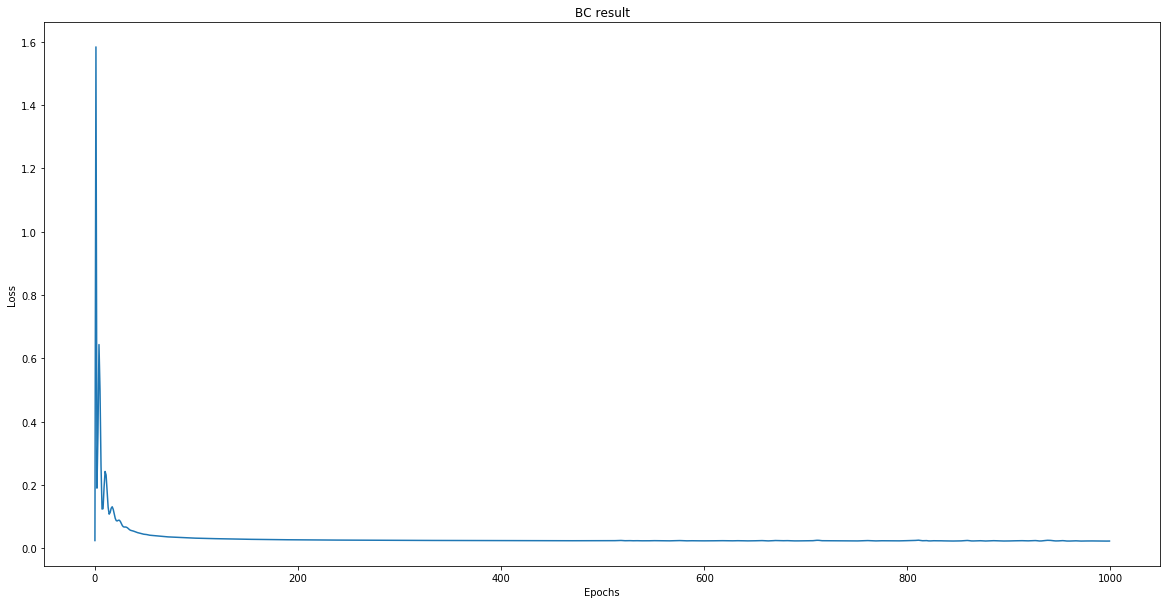

[2018-04-08 21:53:05,058] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [1088.0012531665411, 10484.084932010543, 10424.061922698007]
mean return 7332.049369291697
std of return 4415.276763524291
iter: 18
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


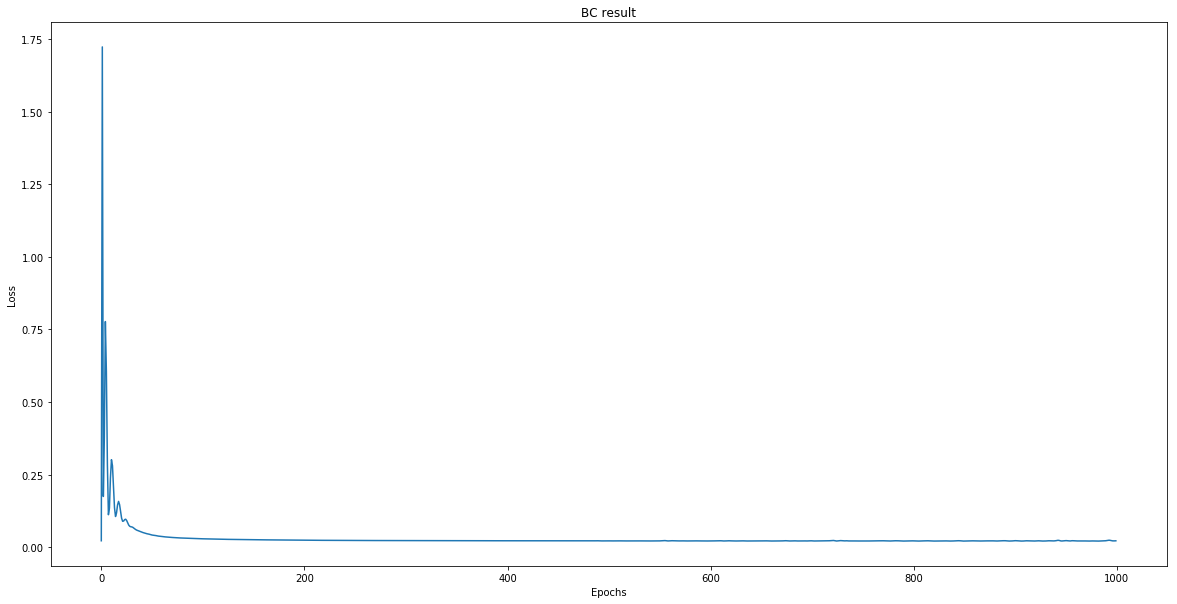

[2018-04-08 21:53:16,212] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [9597.68655292152, 8705.238217323607, 10417.765103946682]
mean return 9573.563291397268
std of return 699.3442324357181
iter: 19
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


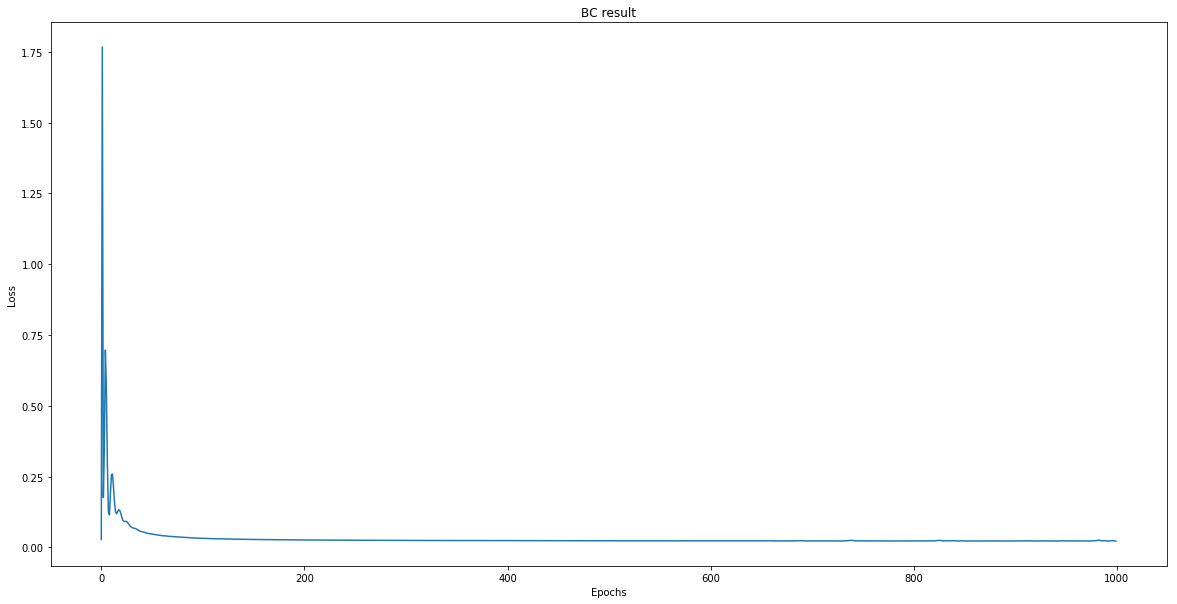

[2018-04-08 21:53:28,595] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10456.142594011797, 10379.034552305366, 8291.74128233905]
mean return 9708.97280955207
std of return 1002.6283172471789


In [46]:
# Step 1: Do a simple behaviour cloning
expert_data = orig_expert_data.copy()
policy_network = BCAgent(expert_data)

# Step 2: Gather some data from the shifted domain (D_pi)
policy_fn = policy_wrapper(policy_network)
agent_data, agent_returns = TestAgent(
    policy_fn, env_name=env_name, 
    render=False, num_rollouts=num_rollouts)

num_dagger = 20
num_rollouts = 3

agent_rewards = []

iter: 0
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


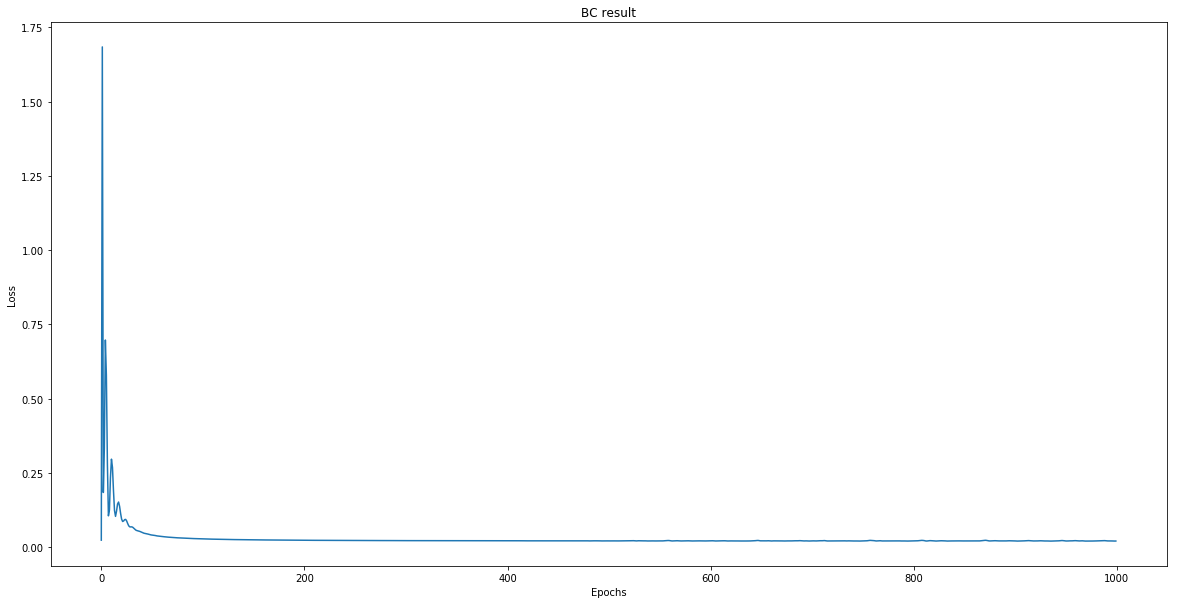

[2018-04-08 23:39:18,145] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10391.071756428342, 10134.535561746601, 10292.779677344624]
mean return 10272.79566517319
std of return 105.67946931578241
iter: 1
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


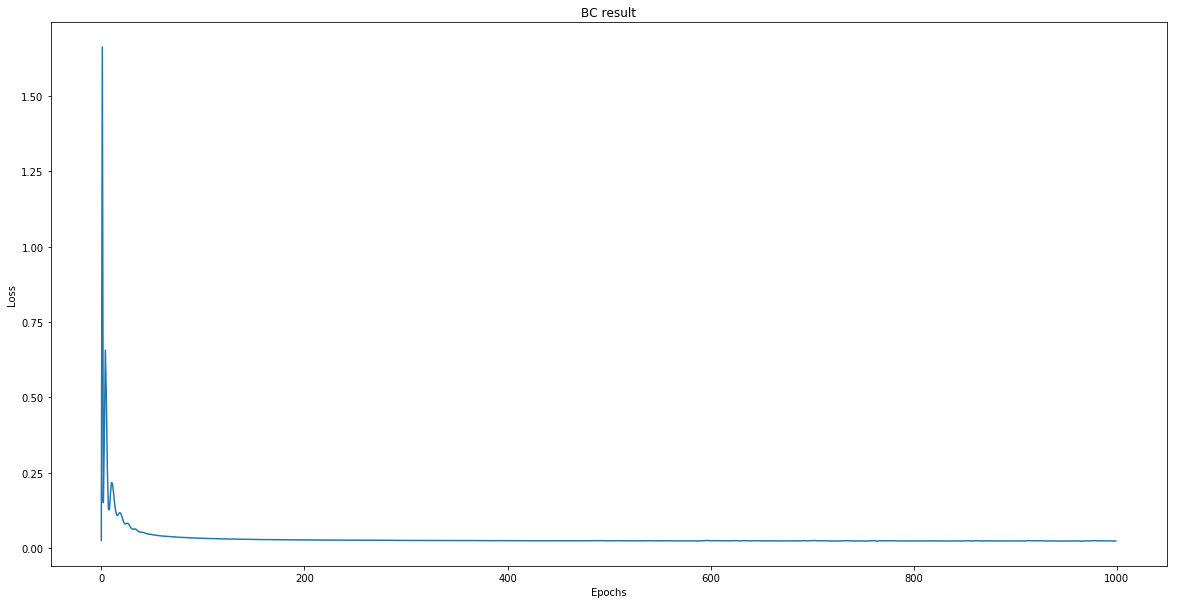

[2018-04-08 23:39:29,086] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [4001.5714528620465, 10288.53574502503, 10382.750687098689]
mean return 8224.285961661923
std of return 2986.157785622322
iter: 2
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


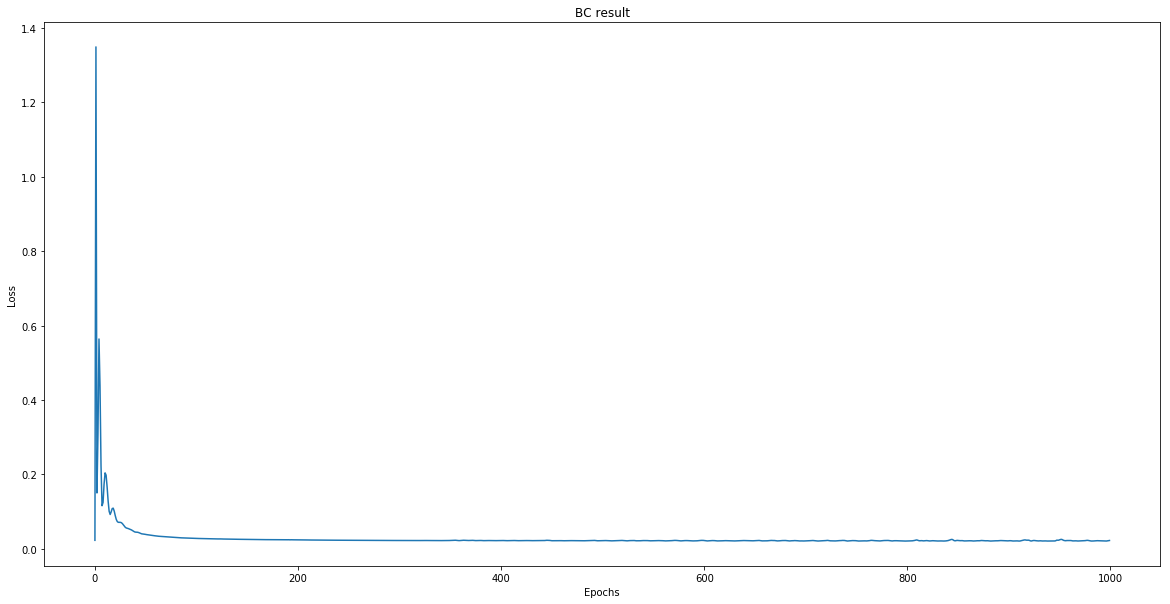

[2018-04-08 23:39:42,154] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [729.6967013422081, 10484.08481639491, 7713.313752936914]
mean return 6309.031756891345
std of return 4104.146506326145
iter: 3
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


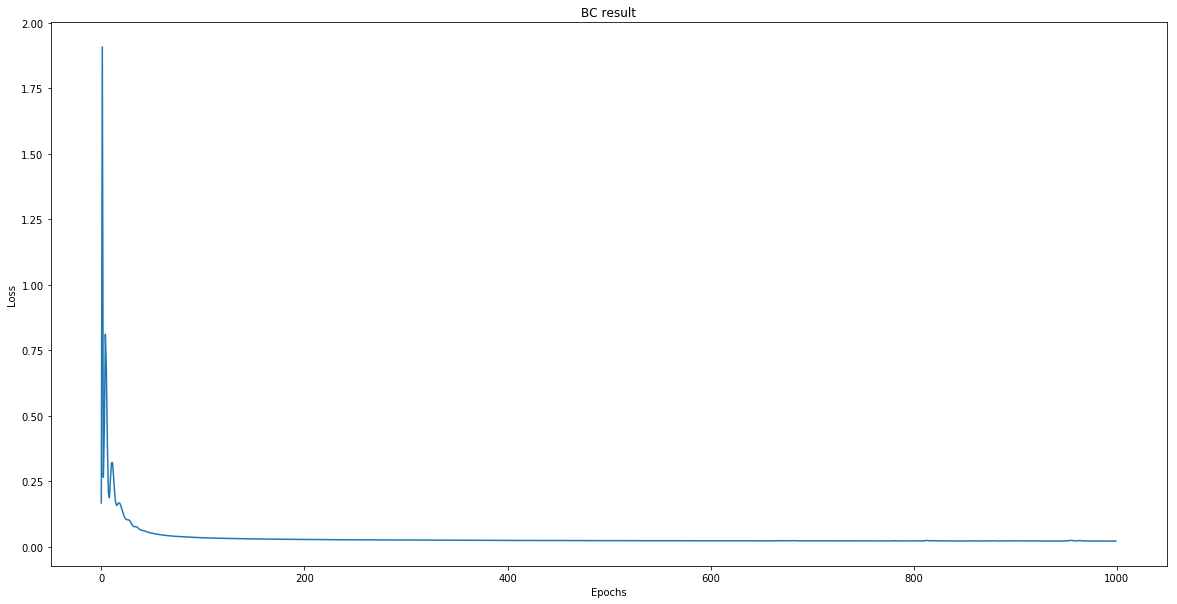

[2018-04-08 23:39:52,927] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [732.1660283427118, 10251.44404374299, 10438.334136655712]
mean return 7140.648069580471
std of return 4532.1233825038635
iter: 4
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


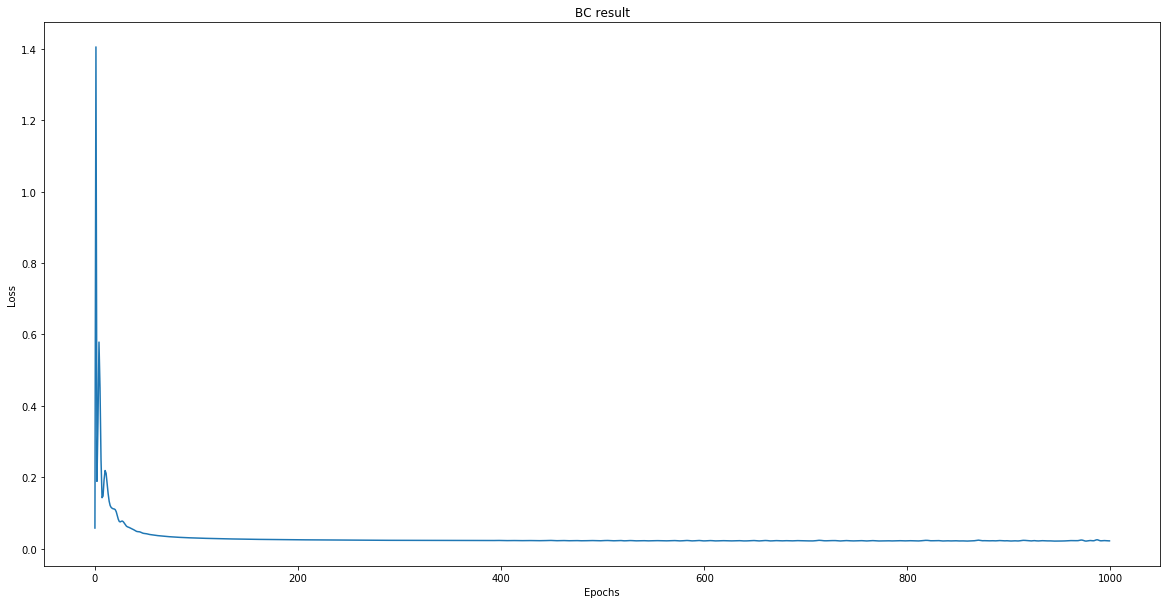

[2018-04-08 23:40:02,237] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10392.80455024849, 10384.32105457217, 10374.814601586324]
mean return 10383.980068802328
std of return 7.34832256088702
iter: 5
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


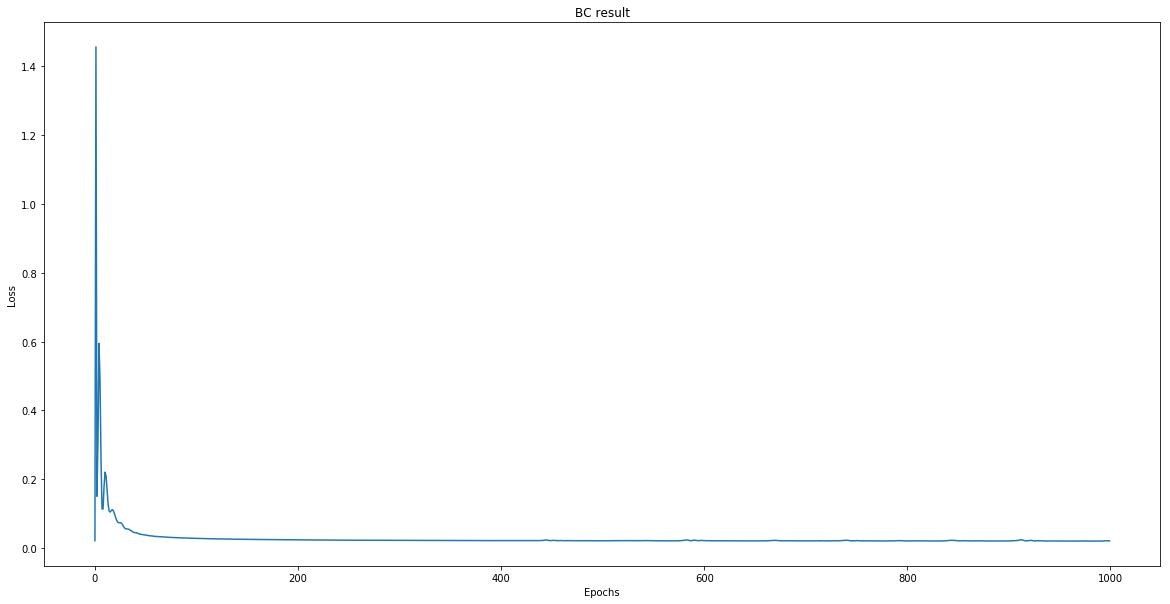

[2018-04-08 23:40:13,082] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10479.46774996164, 4113.376430899031, 10339.659463449329]
mean return 8310.834548103332
std of return 2968.5998465615166
iter: 6
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


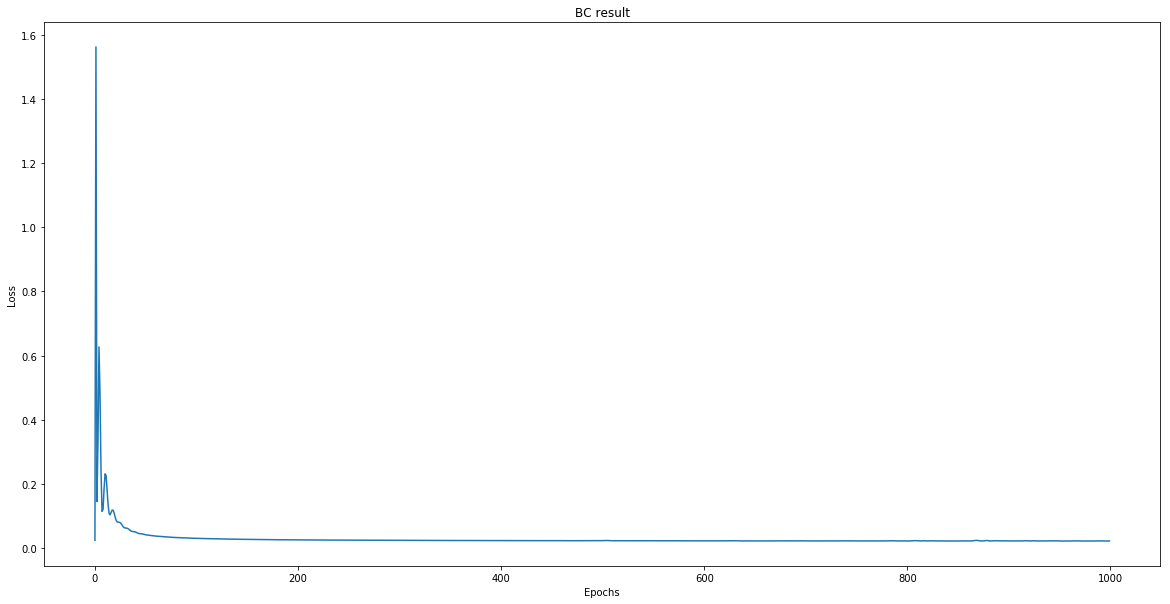

[2018-04-08 23:40:25,018] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [1514.3098305937, 10342.953449161218, 10345.253382684547]
mean return 7400.838887479821
std of return 4162.404719678038
iter: 7
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


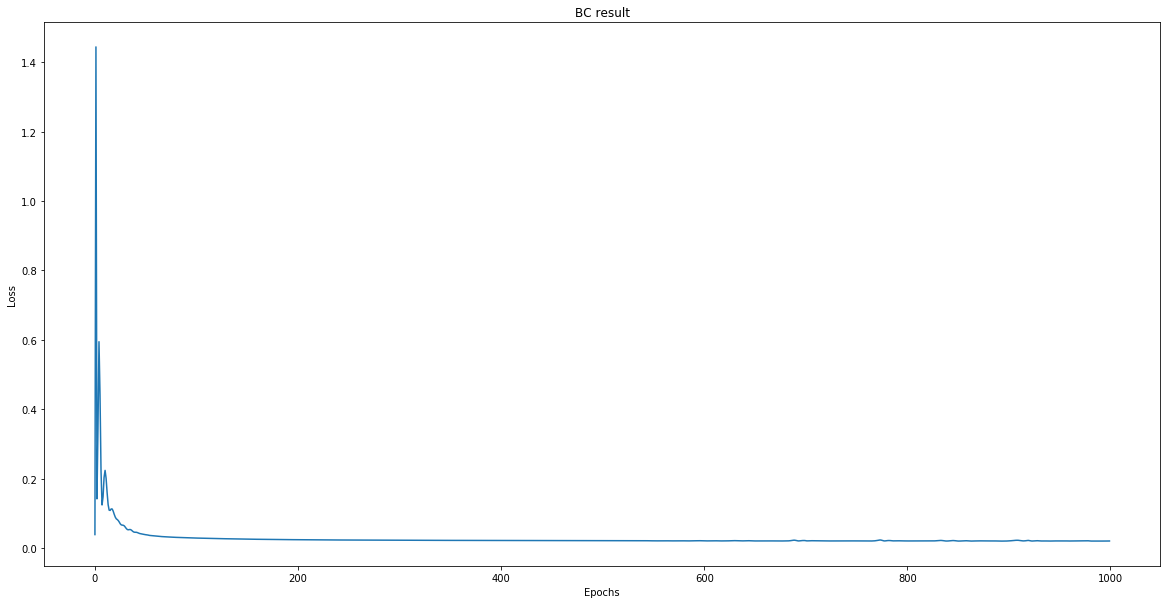

[2018-04-08 23:40:37,415] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10519.241345003538, 10369.621441543613, 10487.957250802903]
mean return 10458.940012450017
std of return 64.43616463374384
iter: 8
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


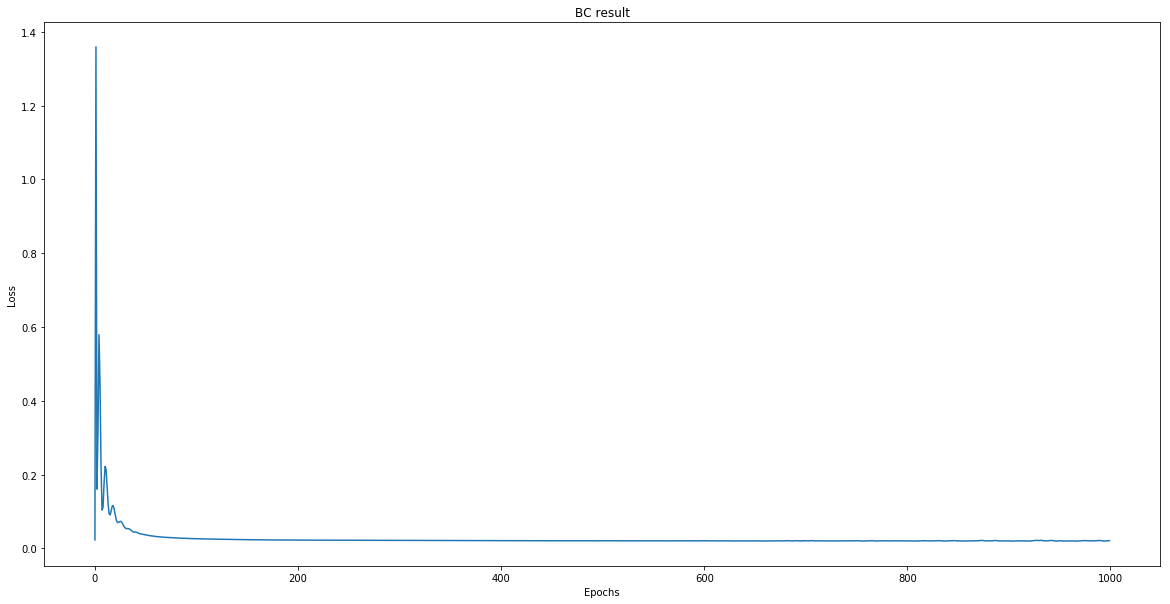

[2018-04-08 23:40:53,307] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [2160.1133015431283, 10386.578345771279, 10309.350323909666]
mean return 7618.680657074691
std of return 3859.9187576075824
iter: 9
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


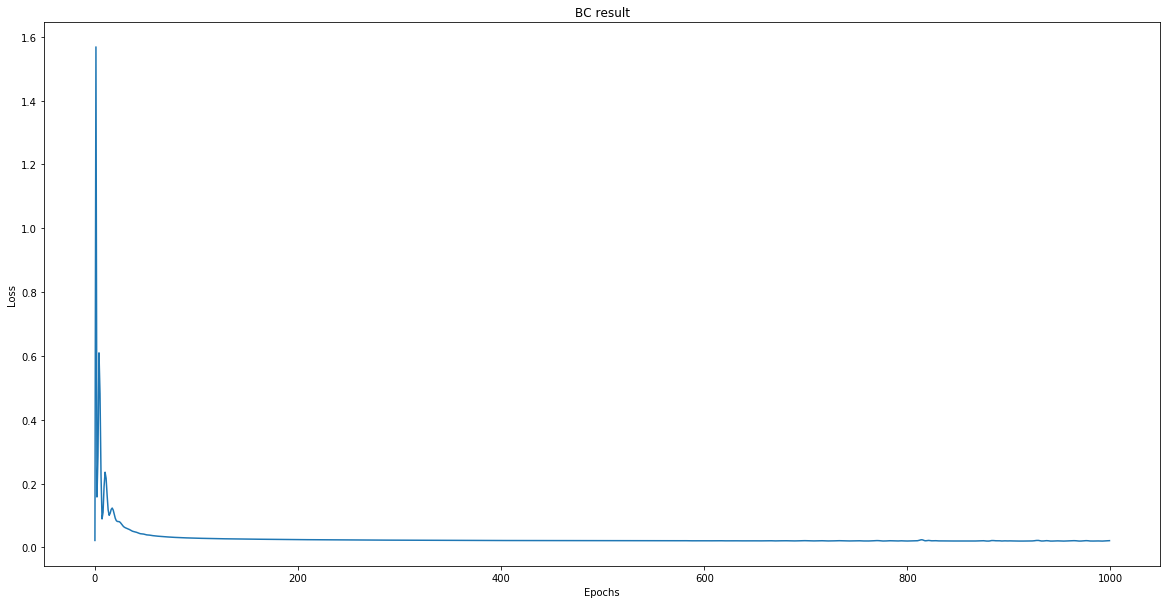

[2018-04-08 23:41:06,896] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10313.27931463327, 10407.259764964841, 10223.453646508111]
mean return 10314.664242035407
std of return 75.04492349459446
iter: 10
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


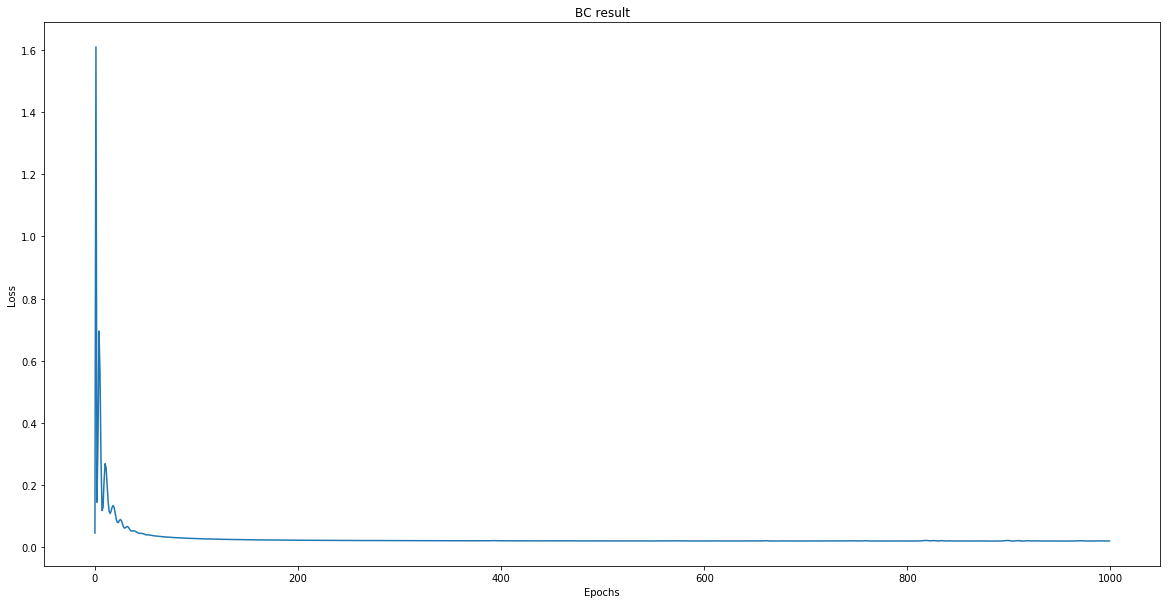

[2018-04-08 23:41:24,546] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [741.2052625445267, 10262.98487123402, 10484.678746738915]
mean return 7162.95629350582
std of return 4541.765572355346
iter: 11
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


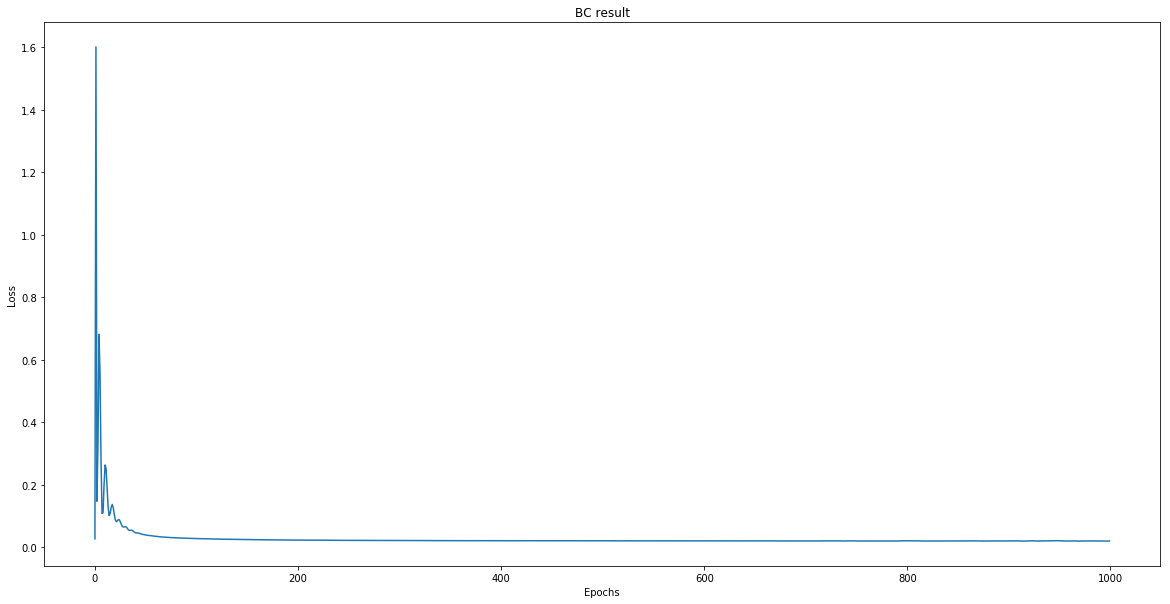

[2018-04-08 23:41:38,594] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10343.452066535927, 10409.54669379648, 10416.392293428811]
mean return 10389.797017920406
std of return 32.88978005099083
iter: 12
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


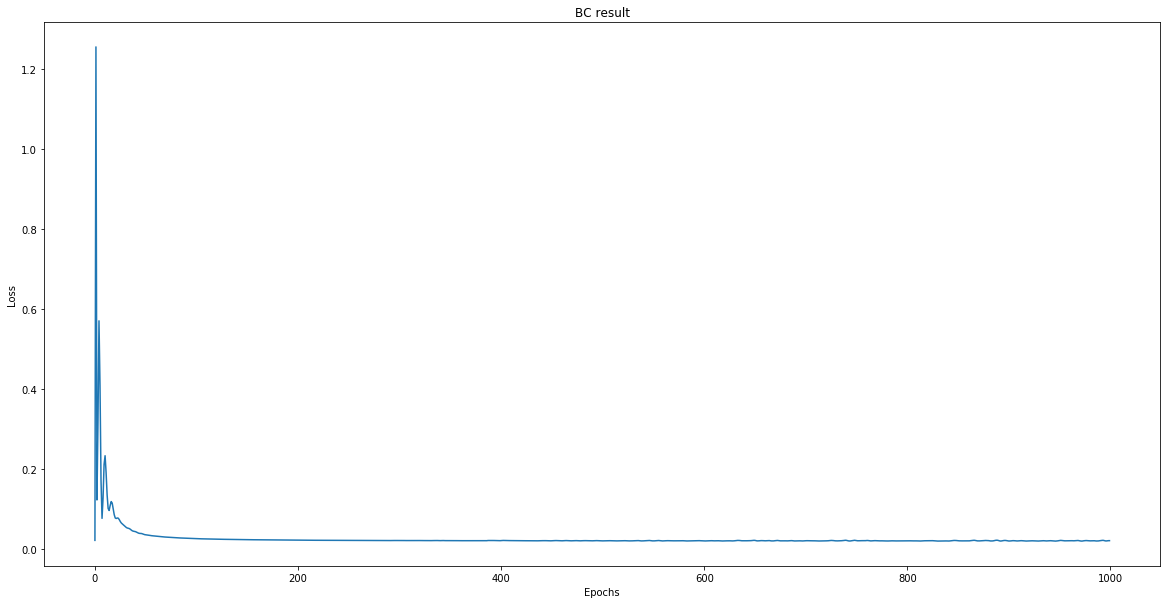

[2018-04-08 23:41:55,587] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10347.837804731362, 10329.903777366, 10443.991940160746]
mean return 10373.911174086037
std of return 50.09253214202053
iter: 13
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


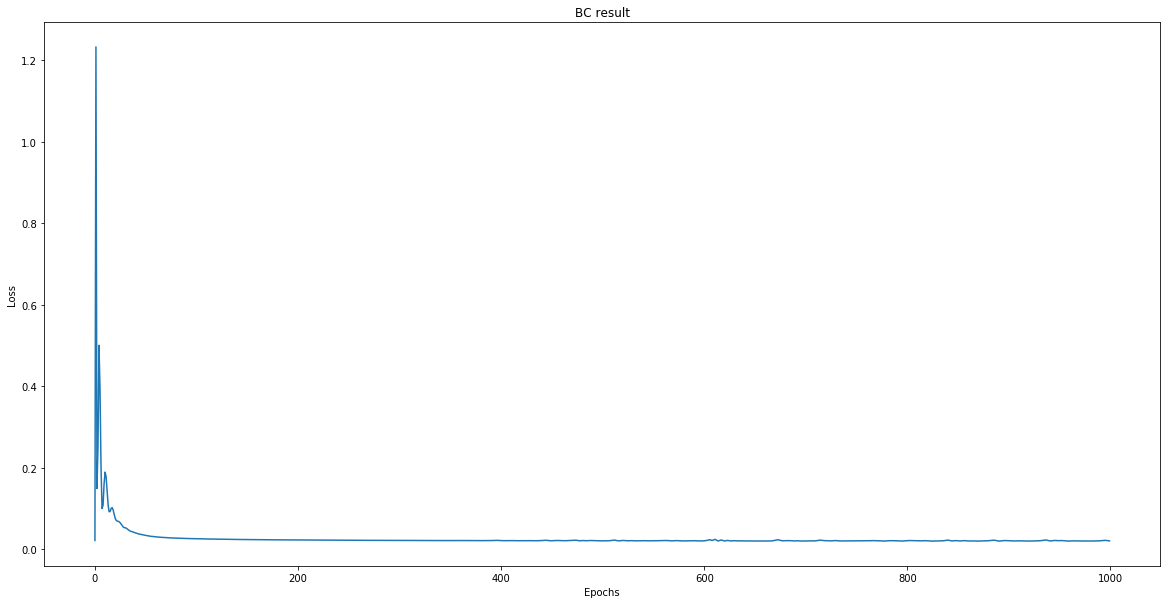

[2018-04-08 23:42:10,382] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10455.239087114847, 10322.44849324849, 10440.875818474964]
mean return 10406.187799612768
std of return 59.50226575116302
iter: 14
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


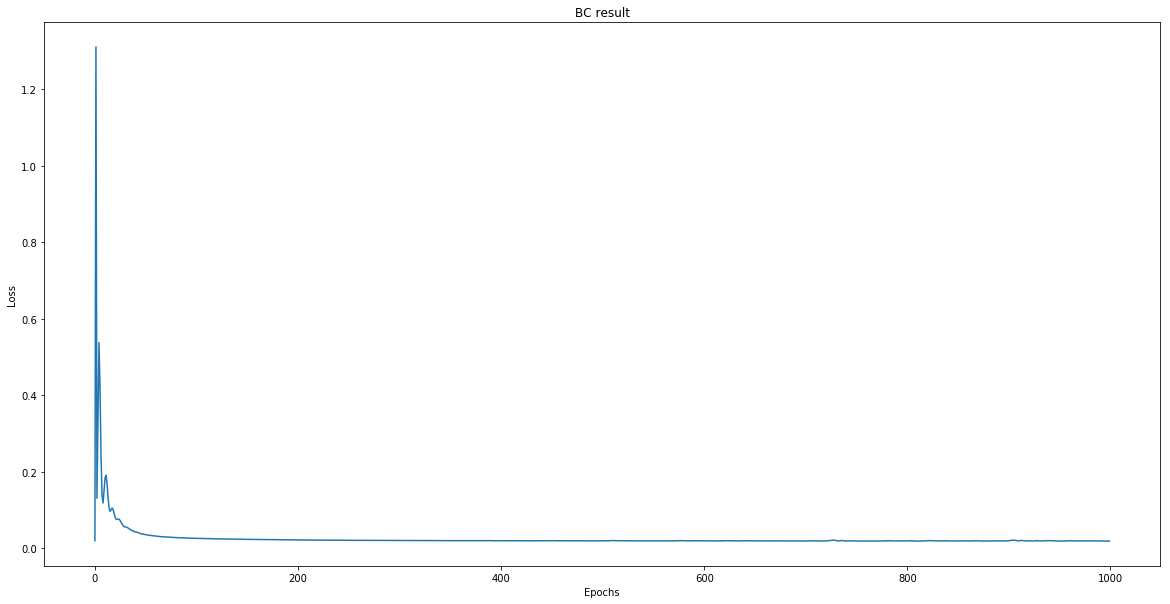

[2018-04-08 23:42:27,332] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10425.981347017621, 10401.672415592026, 10467.512763558529]
mean return 10431.722175389392
std of return 27.18401108351677
iter: 15
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


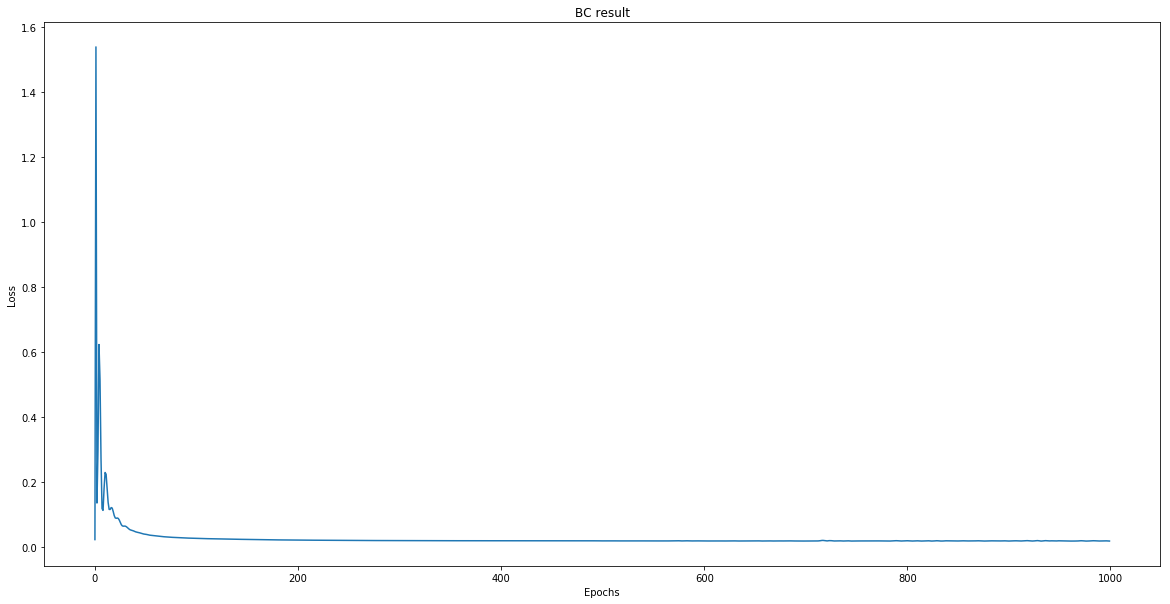

[2018-04-08 23:42:42,101] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [1328.7835532579063, 10361.19253029376, 10301.01570324392]
mean return 7330.33059559853
std of return 4243.805720396026
iter: 16
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


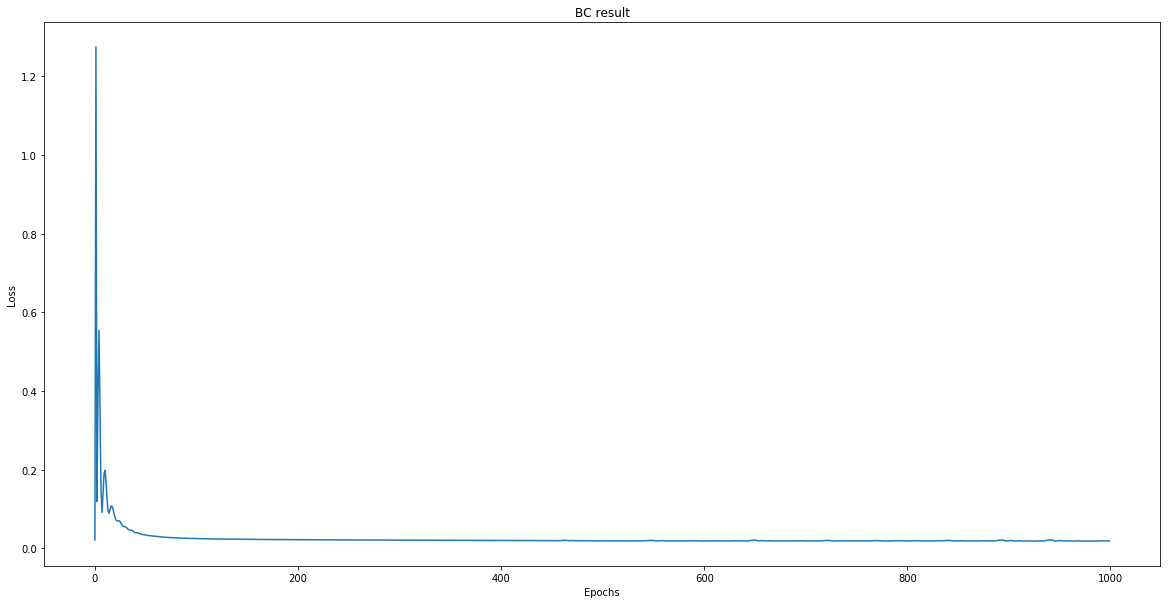

[2018-04-08 23:42:55,056] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10415.104366194728, 10448.370768195799, 10407.797081752607]
mean return 10423.757405381044
std of return 17.658092068841906
iter: 17
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


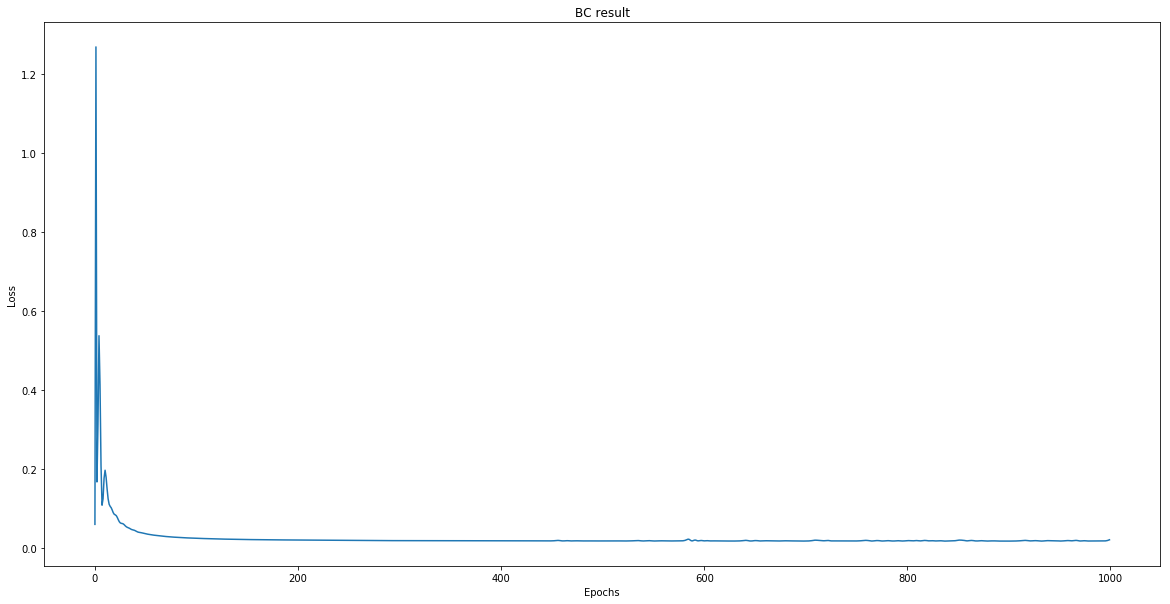

[2018-04-08 23:43:12,274] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10378.541480928714, 10406.779880530592, 2250.5007864124736]
mean return 7678.607382623926
std of return 3838.2682958749974
iter: 18
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


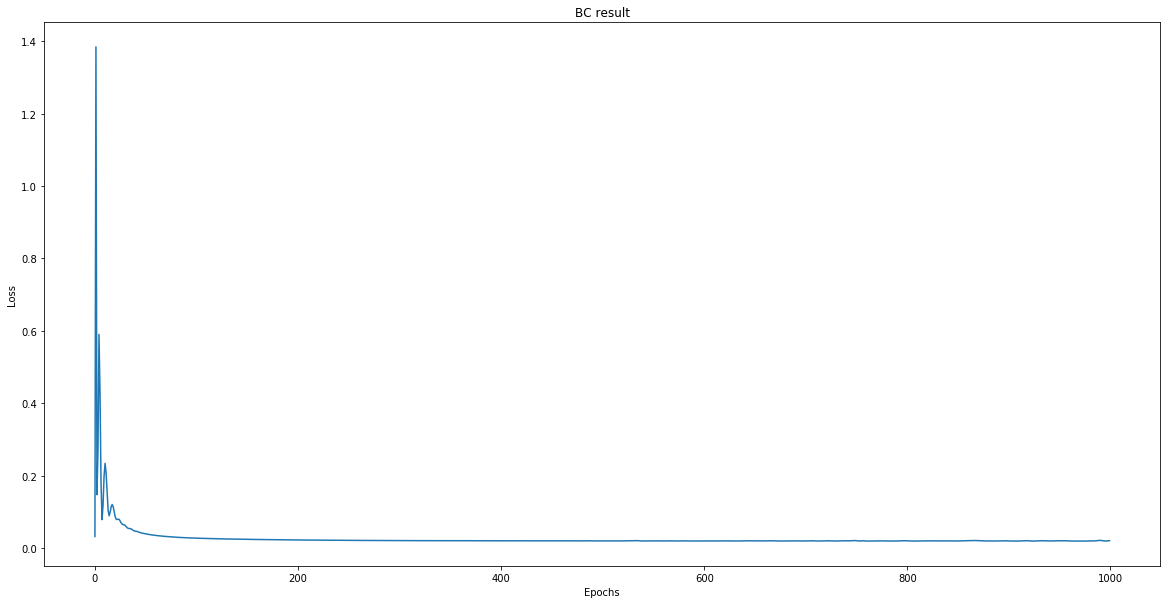

[2018-04-08 23:43:26,099] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [10199.785138568042, 10330.929798443567, 10455.64426100162]
mean return 10328.786399337743
std of return 104.46504440215163
iter: 19
obs (1, 376) (1, 376)
Agent's Policy function:
 Sequential(
  (0): Linear(in_features=376, out_features=64)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


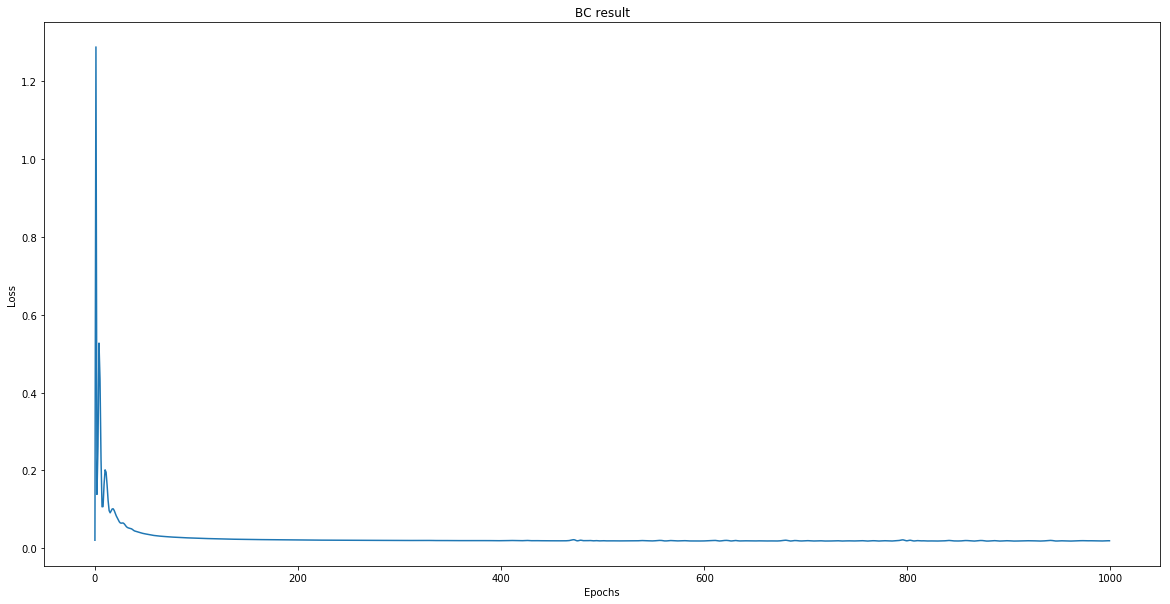

[2018-04-08 23:43:41,241] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [8696.51589757126, 10362.339782299476, 10385.191477604838]
mean return 9814.68238582519
std of return 790.7181426126416


In [52]:
for i in range(num_dagger):
    print('iter:', i)
    # Step 3: Ask expert to label agent's observations (samples of shifted domain D_pi)
    new_expert_data = SolveWithExpert(agent_data, env_name=env_name)
    
    # Step 4: Extend the database with (shifted observations, expert actions)
    dagger_data = Aggregate(expert_data, new_expert_data)
    
    # Step 1:
    policy_network = BCAgent(dagger_data, pretrained_agent=policy_network)
    
    # Step 2:
    policy_fn = policy_wrapper(policy_network)
    agent_data, agent_returns = TestAgent(
        policy_fn, env_name=env_name, 
        render=False, num_rollouts=num_rollouts)
    
    agent_rewards.append(agent_returns)

In [69]:
dagger_rewards = np.array(agent_rewards)
expert_policy_fn = load_policy.load_policy('experts/%s-v1.pkl'%env_name)
with tf.Session():
    tf_util.initialize()
    _, expert_rewards = TestAgent(expert_policy_fn, env_name=env_name, 
                               render=False, num_rollouts=num_rollouts)


[2018-04-08 23:52:32,041] Making new env: Humanoid-v1


obs (1, 376) (1, 376)
iter 0
iter 1
iter 2
returns [10454.68127133824, 10452.105744347635, 10376.458585550674]
mean return 10427.748533745516
std of return 36.282708684184136


### Figure 2

/home/botoscs/.virtualenvs/all/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


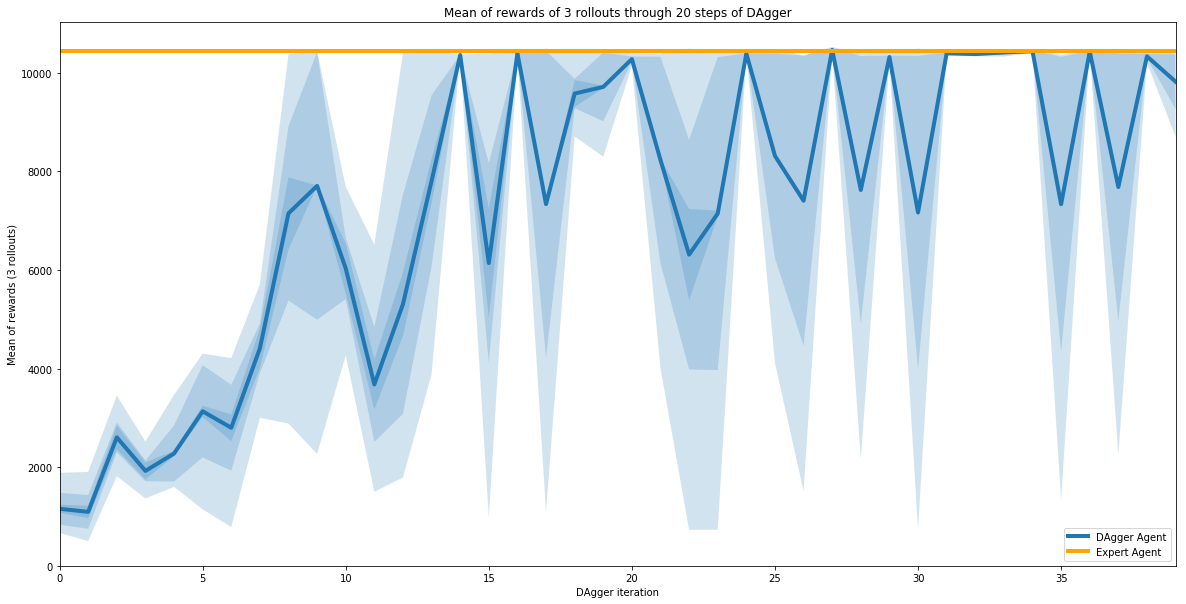

In [94]:
sns.tsplot(dagger_rewards.T, err_style='ci_band', ci=[33, 66, 95])
plt.plot(dagger_rewards.mean(1), linewidth=4, label='DAgger Agent')

plt.plot(np.ones(len(dagger_rewards)) * np.mean(expert_rewards), linewidth=4, 
           color='orange', label='Expert Agent')


plt.title('Mean of rewards of 3 rollouts through 20 steps of DAgger')
plt.xlabel('DAgger iteration')
plt.ylabel('Mean of rewards (3 rollouts)')
plt.legend(loc='lower right')

#### Caption:
I've used the Humanoid-v1 task, which was underperforming in vanilla BC.

Details:
- Network: 64 ReLU
- Optimizer: Adam (1000 epochs)
- Original expert training samples: 20k
- \# DAgger extension: 10
- \# rollouts with the fine-tuned agent: 3

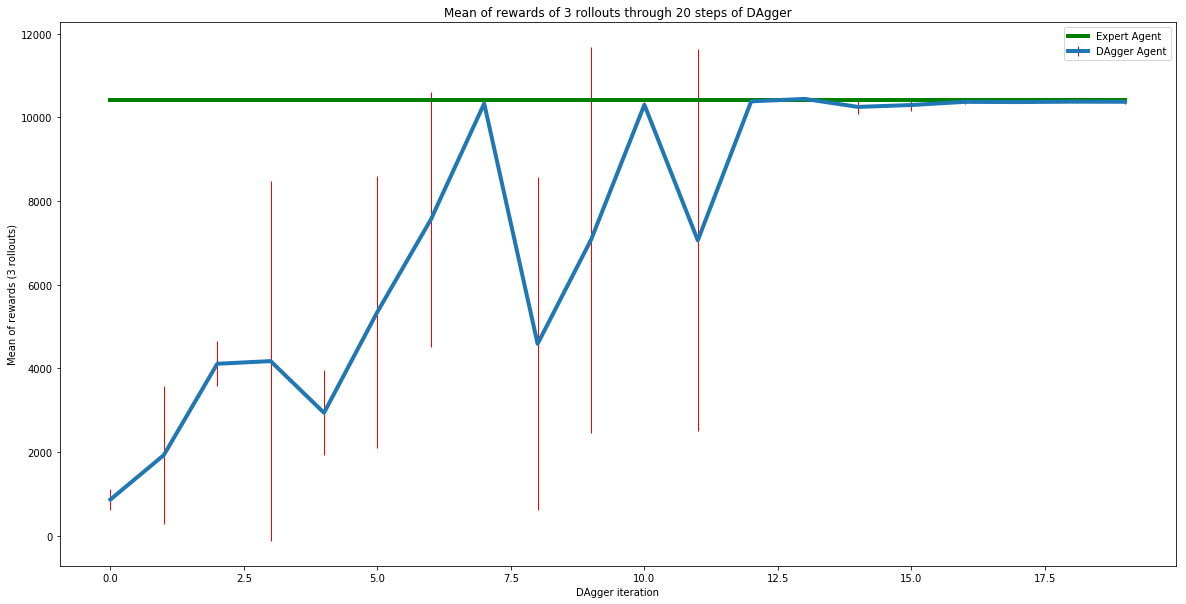

In [68]:
plt.errorbar(range(num_dagger), agent_rewards_mean, agent_rewards_std, 
             ecolor='r', linewidth=4, elinewidth=1, capthick=2, 
             label='DAgger Agent')
plt.plot(expert_mean_rewards, linewidth=4, color='green',
         label='Expert Agent')

plt.title('Mean of rewards of 3 rollouts through 20 steps of DAgger')
plt.xlabel('DAgger iteration')
plt.ylabel('Mean of rewards (3 rollouts)')
plt.legend()
plt.show()

## Section 5. Bonus: Alternative Policy Architectures



Experiment with a different policy architecture, e.g.  using recurrence or changing the size or nonlinearities used.  Compare performance between your new and original policy architectures using behavioral cloning and/or DAgger, and report your results in the same form as above, with a caption describing what you did.

In [149]:
class PolicyLSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.hidden = torch.nn.Linear(input_dim, hidden_dim)
        self.lstm = torch.nn.LSTM(hidden_dim, hidden_dim)
        self.read = torch.nn.Linear(hidden_dim, output_dim)
        # lil bit boilerplate
        
    def forward(self, s, init_lstm_state=None):
        # s for servation
        seq_len, batch_size, input_dim = s.size()
        assert batch_size == 1
        
        if init_lstm_state is None:
            
            if torch.cuda.is_available():
                # The axes semantics are (num_layers, minibatch_size, hidden_dim)
                init_lstm_state = (Variable(torch.zeros(1, 1, self.hidden_dim)).cuda(),
                                   Variable(torch.zeros(1, 1, self.hidden_dim)).cuda())
            else:
                init_lstm_state = (Variable(torch.zeros(1, 1, self.hidden_dim)),
                                   Variable(torch.zeros(1, 1, self.hidden_dim)))
        
        
        s = self.hidden(s)
        s = torch.nn.functional.relu(s)
        s, self.final_lstm_state = self.lstm(s, init_lstm_state)
        # usually non-lin is not required here...
        s = torch.tanh(s)
        # a for action
        a = self.read(s)
        return a



In [109]:
# Just a unit check
policy_net = PolicyLSTM(7, 5, 3)
print(policy_net)
obs = Variable(FloatTensor(1000, 1, 7))
print(obs.shape)

PolicyLSTM(
  (hidden): Linear(in_features=7, out_features=5)
  (lstm): LSTM(5, 5)
  (read): Linear(in_features=5, out_features=3)
)
torch.Size([1000, 1, 7])


In [117]:
def GenerateExpertData(env_name, num_rollouts=20, render=False, episode_dim=False):
    """
    NEW: Instead of concatenating all states and actions into a single dimension
         using the `episode_dim` flag we will concatenate rollouts along a new axis
         final structure: [num_rollouts, rollout_length(var), state_dim/action_dim]
    
    Generates a database of expert observation-action pair of size `num_rollouts` 
    """

    print('loading and building expert policy')
    policy_fn = load_policy.load_policy('experts/%s-v1.pkl'%env_name)
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()
        env = gym.make(env_name+'-v1')
        max_steps = env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(num_rollouts):
            rollout_observations = []
            rollout_actions = []
            print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = policy_fn(obs[None,:])
                if episode_dim:
                    rollout_observations.append(obs)
                    rollout_actions.append(action)
                else:
                    observations.append(obs)
                    actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                if render:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
                    
            observations.append(rollout_observations)
            actions.append(rollout_actions)
            returns.append(totalr)
        
        if render:
            env.render(close=True)

        print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))
        
        expert_data = {'observations': np.array(observations),
                       'actions': np.array(actions).squeeze()}
        print('Observations dim', expert_data['observations'].shape)
        print('Actions dim', expert_data['actions'].shape)
    return expert_data


In [ ]:
# Just a unit check
expert_lstm_data = GenerateExpertData('Humanoid', num_rollouts=3, episode_dim=True)

In [121]:
# Compatibility check...

input_dim = expert_lstm_data['observations'].shape[-1]
output_dim = expert_lstm_data['actions'].shape[-1]

policy_net = PolicyLSTM(input_dim, 7, output_dim)
print(policy_net)
obs = Variable(FloatTensor(expert_lstm_data['observations']))
"""
What we have now...
shape: [num_rollouts, rollout_length, obs/act_dim]
RNN requires: [sequence_length, batch_size, *]

Ideally every single run would be the same length, however that is not always true...
So we could mess around with padding and packing to do batch training
Or just train the rollouts separately

So we just select the i_th rollout, and set the batch_size to 1
and leave the rest (*) which looks like the following: 
obs[i, :, None, ...]
"""
act = policy_net(obs[0, :, None])
print(act.shape)

PolicyLSTM(
  (hidden): Linear(in_features=376, out_features=7)
  (lstm): LSTM(7, 7)
  (read): Linear(in_features=7, out_features=17)
)
torch.Size([1000, 1, 17])


In [139]:
def RecurrentBCAgent(expert_data, hidden_dim=64, num_epochs=1000, 
            loss_fn=torch.nn.MSELoss(), pretrained_agent=None):
    # STEP 1: Define policy-network
    if pretrained_agent:
        # Useful if you want to fine-tune the policy-network
        policy_net = pretrained_agent
    else:        
        input_dim = expert_data['observations'].shape[-1]
        output_dim = expert_data['actions'].shape[-1]
        policy_net = PolicyLSTM(input_dim, hidden_dim, output_dim)
    print('Agent\'s Policy function:\n', policy_net)
    
    # STEP 2: Load the training data into PyTorch Tensors
    X = Variable(FloatTensor(expert_data['observations']))
    Y = Variable(FloatTensor(expert_data['actions']))
    if torch.cuda.is_available():
        X = X.cuda()
        Y = Y.cuda()
        policy_net.cuda()
    # STEP 3: Initialize and do the training    
    opt = torch.optim.Adam(policy_net.parameters())
    losses = []
    for epoch in range(num_epochs):
        if epoch % (num_epochs//10) == 0: print('Epoch:', epoch)
        for rollout_idx in range(len(X)):
            opt.zero_grad()
            actions = policy_net(X[rollout_idx, :, None])
            loss = loss_fn(actions, Y[rollout_idx, :, None])
            loss.backward()
            opt.step()
            losses.append(loss.cpu().data.numpy())

    print('Behaviour cloning finished')
    plt.plot(losses)
    plt.title('BC result')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.show()
    
    return policy_net

#### The razor-tooth learning curve

when the optimization step occurs after every single expert rollout we end up with a curve like the following plot... which actually makes sense

Agent's Policy function:
 PolicyLSTM(
  (hidden): Linear(in_features=376, out_features=64)
  (lstm): LSTM(64, 64)
  (read): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Behaviour cloning finished


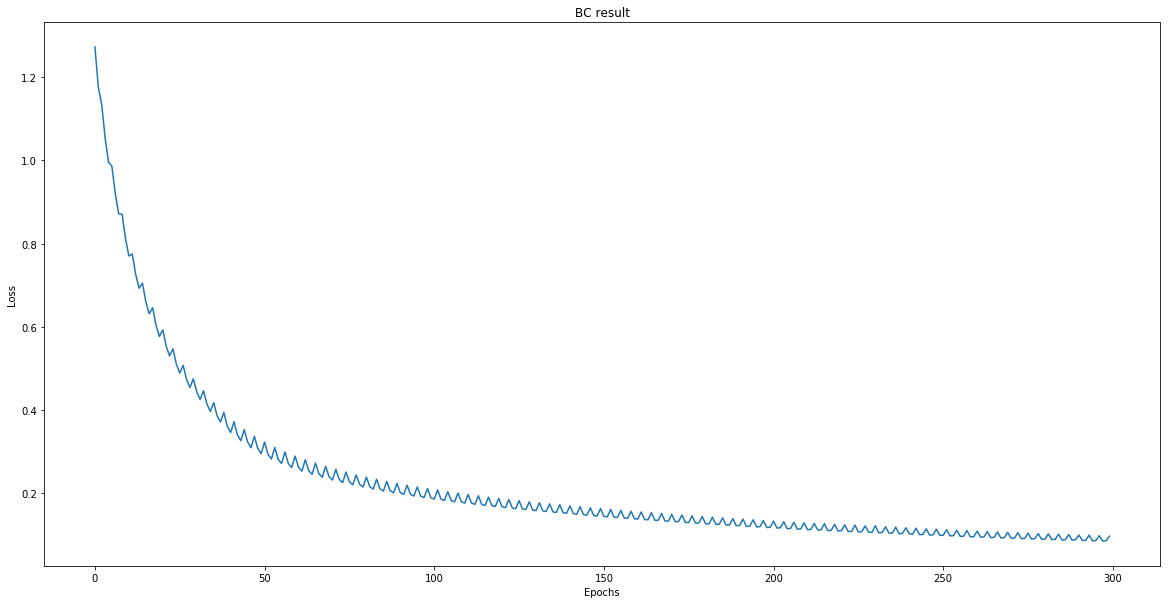

In [138]:
trained_lstm_policy_net = RecurrentBCAgent(expert_lstm_data, num_epochs=100)

In [172]:
def RecurrentBCAgent(expert_data, hidden_dim=64, num_epochs=1000, 
            loss_fn=torch.nn.MSELoss(), pretrained_agent=None):
    
    # STEP 1: Define policy-network
    if pretrained_agent:
        # Useful if you want to fine-tune the policy-network
        policy_net = pretrained_agent
    else:        
        input_dim = expert_data['observations'].shape[-1]
        output_dim = expert_data['actions'].shape[-1]
        policy_net = PolicyLSTM(input_dim, hidden_dim, output_dim)
    print('Agent\'s Policy function:\n', policy_net)
    
    if torch.cuda.is_available():
        policy_net.cuda()
        
    # STEP 2: Initialize and do the training    
    opt = torch.optim.Adam(policy_net.parameters())
    losses = []
    for epoch in range(num_epochs):
        if epoch % (num_epochs//10) == 0: print('Epoch:', epoch)
        opt.zero_grad()
        for rollout_idx in range(len(expert_data)):    
            X = Variable(FloatTensor(expert_data['observations'][rollout_idx]))
            Y = Variable(FloatTensor(expert_data['actions'][rollout_idx]))
            if torch.cuda.is_available():
                X = X.cuda()
                Y = Y.cuda()
            actions = policy_net(X[:, None])
            loss = loss_fn(actions, Y[:, None])
            loss.backward()
        losses.append(loss.cpu().data.numpy())
        opt.step()

    print('Behaviour cloning finished')
    plt.plot(losses)
    plt.title('BC result')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.show()
    
    return policy_net

#### Smooth learning curve
Opt steps now only made when every rollout have been processed

Agent's Policy function:
 PolicyLSTM(
  (hidden): Linear(in_features=376, out_features=64)
  (lstm): LSTM(64, 64)
  (read): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Behaviour cloning finished


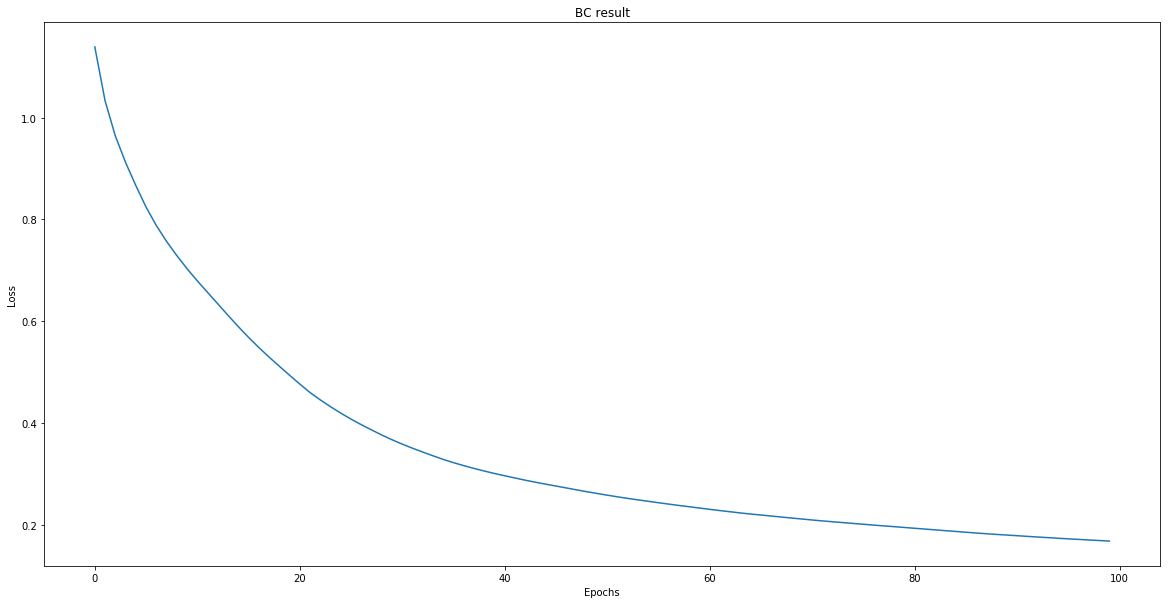

In [173]:
trained_lstm_policy_net = RecurrentBCAgent(expert_lstm_data, num_epochs=100)

#### Comparison with the previous algorithms

The comparison may be unfair because of the capacity advantage of the LSTM policy network.

Agent's Policy function:
 PolicyLSTM(
  (hidden): Linear(in_features=376, out_features=64)
  (lstm): LSTM(64, 64)
  (read): Linear(in_features=64, out_features=17)
)
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Behaviour cloning finished


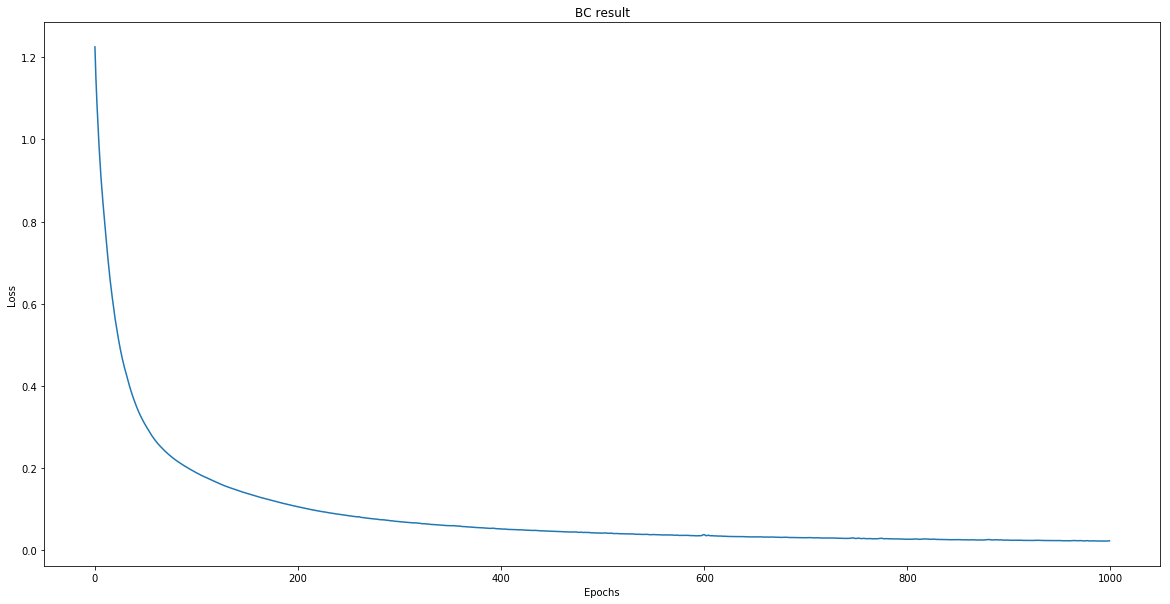

In [174]:
trained_lstm_policy_net = RecurrentBCAgent(expert_lstm_data, num_epochs=1000)

In [180]:
def TestLSTMAgent(policy_net, env_name, render=False, 
              num_rollouts=3, show_after_done=False):
    
    """
    This MuJoCo tester is only for PyTorch recurrent policy networks
    """
    returns = []
    observations = []
    actions = []
    env = gym.make(env_name+'-v1')
    for i in range(num_rollouts):
        print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        
        # Now we should keep track of recent states of the LSTM policy network
        if torch.cuda.is_available():
            # The axes semantics are (num_layers, minibatch_size, hidden_dim)
            init_lstm_state = (Variable(torch.zeros(1, 1, policy_net.hidden_dim)).cuda(),
                               Variable(torch.zeros(1, 1, policy_net.hidden_dim)).cuda())
        else:
            init_lstm_state = (Variable(torch.zeros(1, 1, policy_net.hidden_dim)),
                               Variable(torch.zeros(1, 1, policy_net.hidden_dim)))
        
        # show_after_done is just a funny feature that enables you to watch agents
        # do some weird break-dance moves even if the env would stop them to do so
        rollout_observations = []
        rollout_actions = []
        while not done or show_after_done:
            # dim orders [seq_length=1, batch_size=1, obs_dim]
            X = Variable(FloatTensor(obs[None, None, :]))
            if torch.cuda.is_available():
                X = X.cuda()
            action = policy_net(X, init_lstm_state)
            init_lstm_state = policy_net.final_lstm_state
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            rollout_observations.append(obs)
            rollout_actions.append(action.cpu().data.numpy())
            if render:
                env.render()
            #if steps % 100 == 0: print("%i/%i"%(steps, env.spec.timestep_limit))
            if steps >= env.spec.timestep_limit:
                break
        observations.append(rollout_observations)
        actions.append(rollout_actions)
        returns.append(totalr)

    if render:
        env.render(close=True)
    
    print('returns', returns)
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))
    agent_data = {'observations': observations,
                  'actions': actions}
    return agent_data, returns

In [181]:
lstm_agent_data, lstm_agent_returns = TestLSTMAgent(trained_lstm_policy_net, 'Humanoid', 
                                                    render=True)

[2018-04-09 02:54:05,063] Making new env: Humanoid-v1


iter 0
iter 1
iter 2
returns [1053.6039261643587, 393.50842490814006, 455.86866800581294]
mean return 634.3270063594372
std of return 297.5646166136325


#### LSTM policy network runs pretty slowly... 
However I think the resulting behaviour is quite familiar to classic saturdays' nights

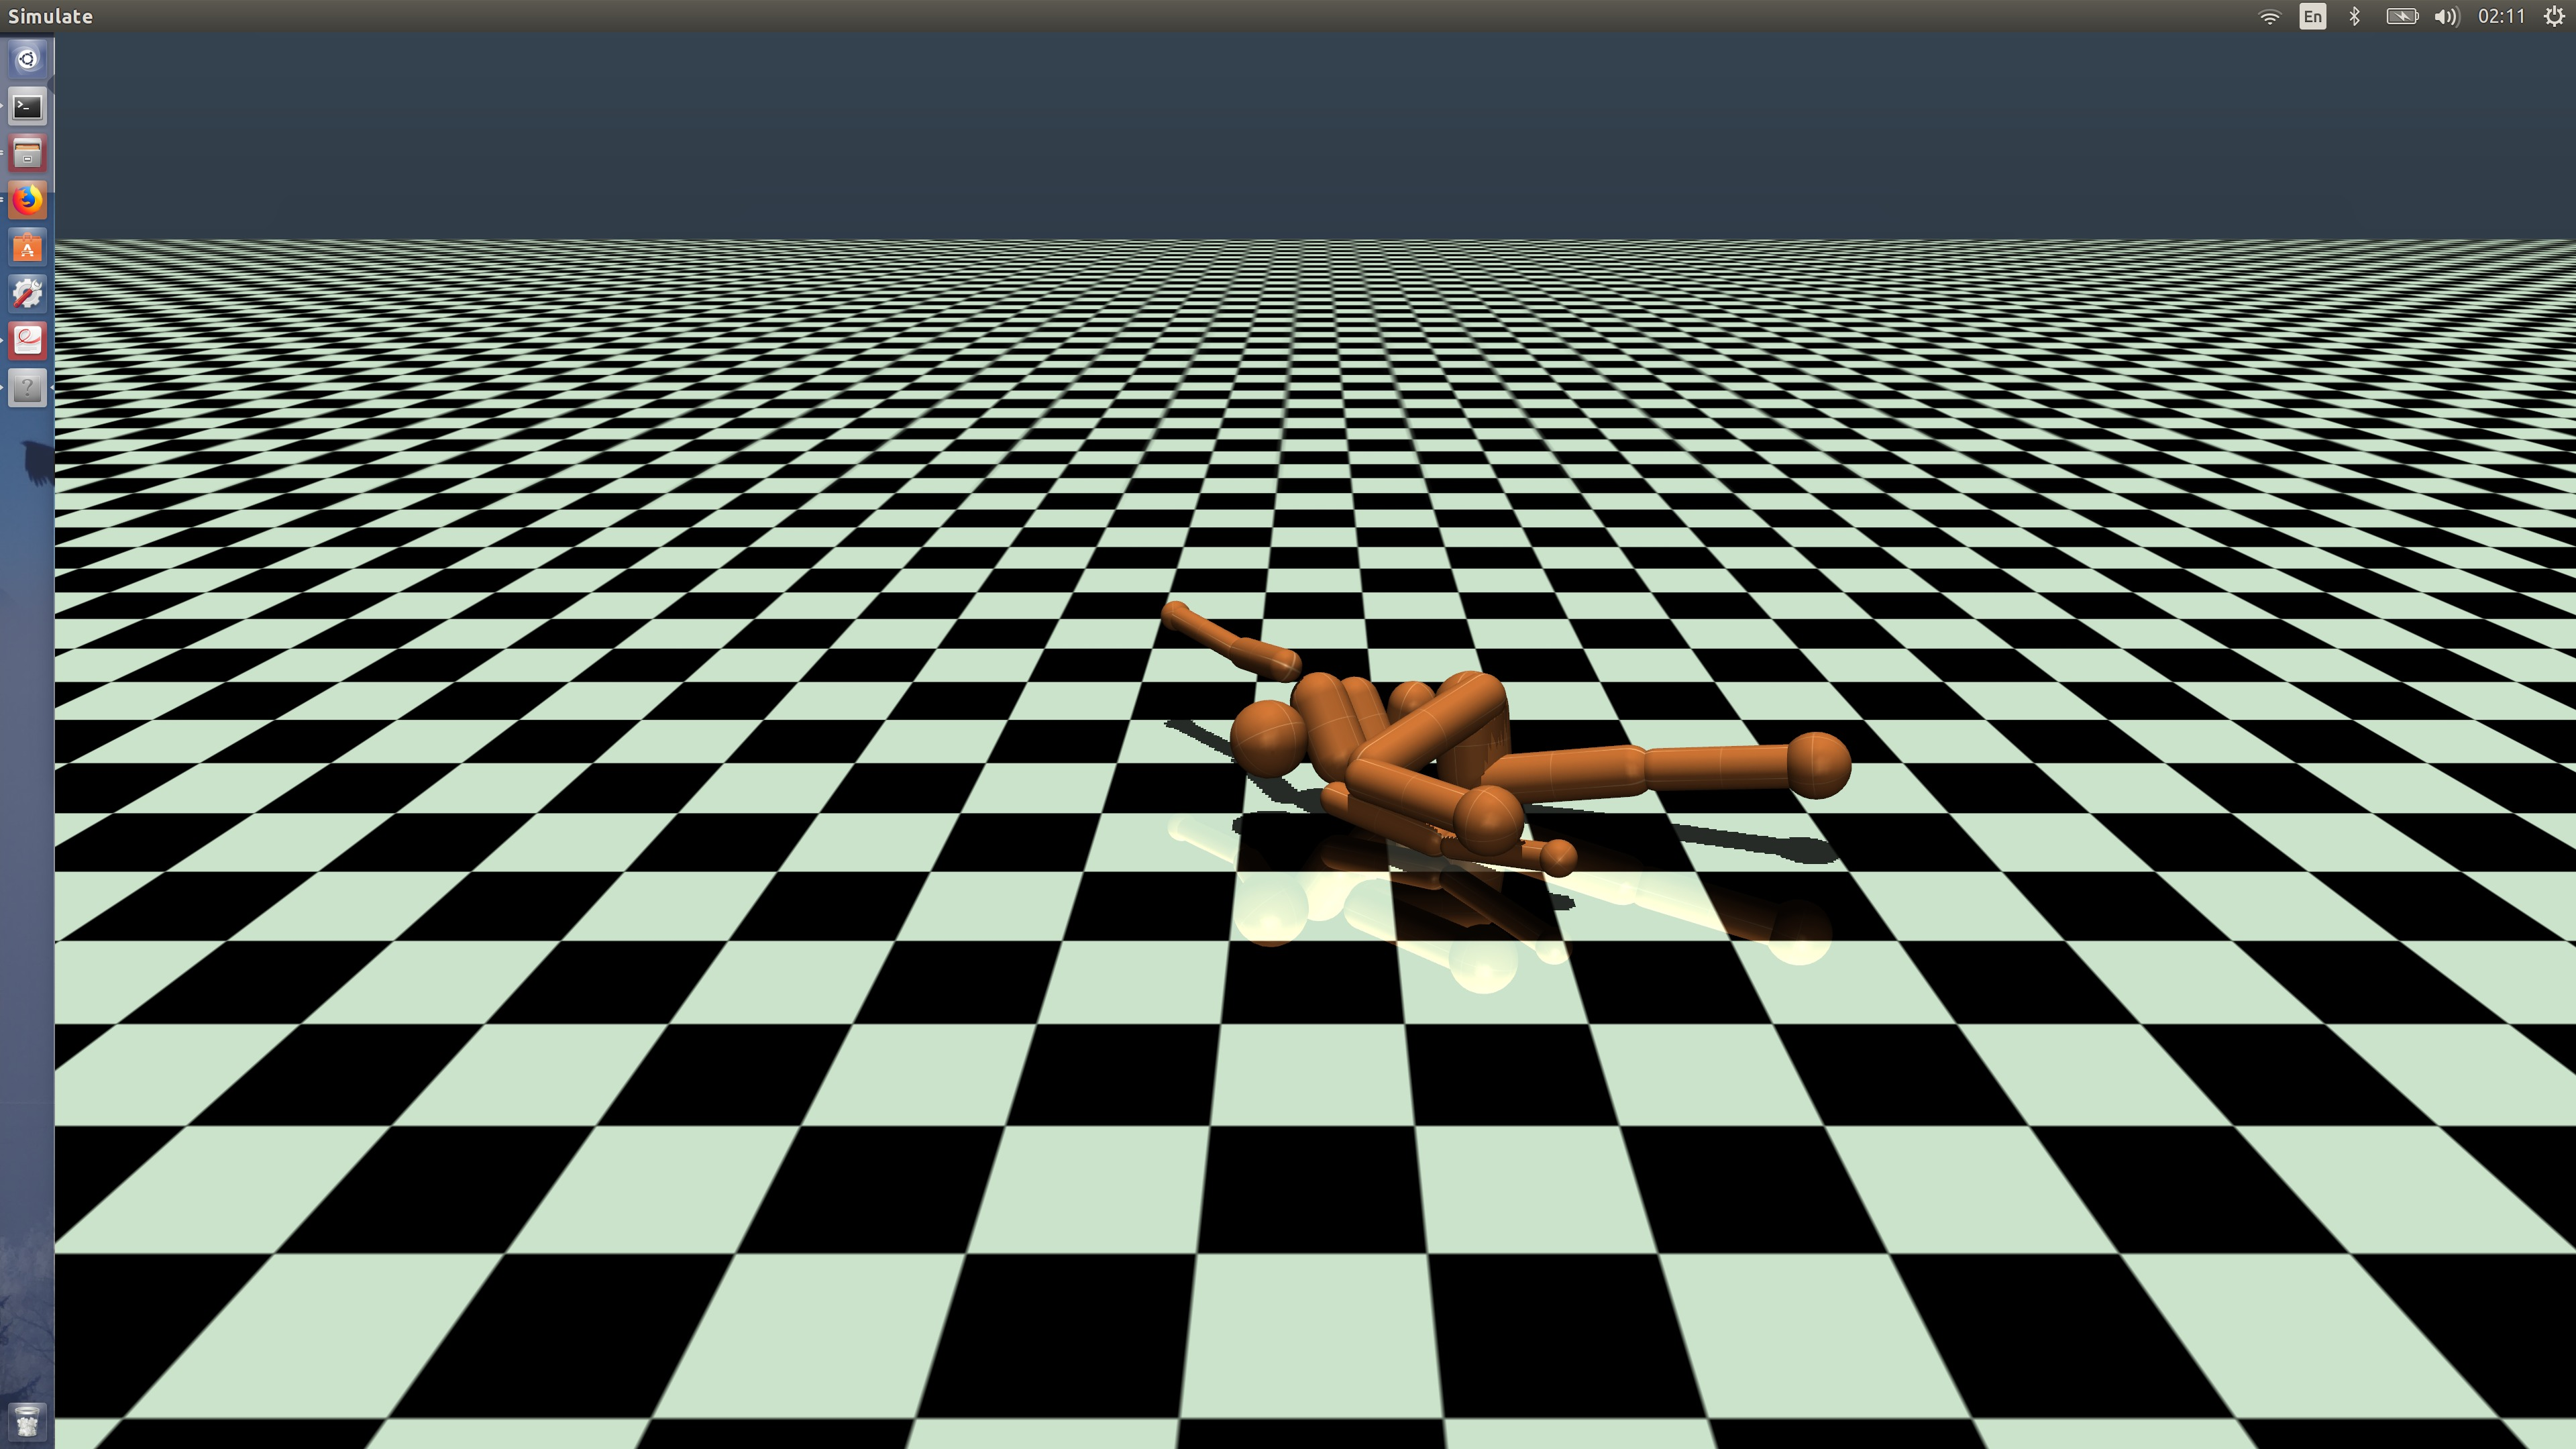